In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.insert(0, "../../")

import os
import logging
from functools import partial
from itertools import combinations

import numpy as np
import jax
from jax import random
from jax import numpy as jnp
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
from flax.core import frozen_dict
import distrax
import wandb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

import src.models as models
from src.models import make_PoG_Ens_loss, make_Reg_Ens_loss, make_PoN_Ens_loss, make_PoN_Ens_GMM_loss
from src.models import make_PoG_Ens_plots, make_Reg_Ens_plots, make_PoN_Ens_plots, make_PoN_Ens_GMM_plots
import src.data
from src.data import NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.comparison_figures_pog import get_config as get_pog_config
from experiments.configs.comparison_figures_reg_ens import get_config as get_reg_ens_config
from experiments.configs.comparison_figures_pon import get_config as get_pon_config
from experiments.configs.comparison_figures_pogmm import get_config as get_pogmm_config
from src.models.pog import calculate_pog_loc_scale
from src.models.reg_ens import calculate_ens_loc_scale
from src.models.pon import normal_prod
from src.models.pon_gmm import monte_carlo_pred
from src.models.common import MembersLL
from src.utils.notebook_metrics_regression import *

2022-11-08 18:38:42.007229: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 18:38:42.611664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-08 18:38:42.611738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-08 18:38:42.611745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [4]:
POG_RETRAIN = False
PON_RETRAIN = True
ENS_RETRAIN = True
PON_GMM_RETRAIN = False

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'regression_performance_gap_investigation.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: metodj. Use `wandb login --relogin` to force relogin


True

## 1. PoG training

In [8]:
config = get_pog_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]

In [9]:
MEMBERS_LL = MembersLL.GND
# MEMBERS_LL = MembersLL.gaussian
# BETA_END = [2, 8 ,16]
ALPHAS = [0., 0.5, 1.]
# ALPHAS = [-1.]
BETA_END = [16]
# ALPHAS = [0.]
BETA_START = [2]
# FT_EPOCHS = [0, 10, 25, 50]
FT_EPOCHS = [100]
PRETRAIN = False
STOCHASTIC_SAMPLING_ENS = False

In [10]:
config = get_pog_config()

In [11]:
print(config)

batch_size: 500
dataset:
  heteroscedastic: false
  n_samples: 692
  noise_std: 0.25
  random_seed: 42
dataset_name: gen_simple_1d
epochs: 201
learning_rate: 0.0001
model:
  learn_weights: false
  net:
    depth: 2
    hidden_size: 50
    out_size: 1
  noise: homo
  size: 5
model_name: PoG_Ens
optim:
  momentum: 0.9
  weight_decay: 0.0001
optim_name: sgdw
"\u03B2_schedule":
  end: 16.0
  name: sigmoid
  start: 2.0
  steps: 201



In [13]:
if PRETRAIN:
    i = 0
    rng = random.PRNGKey(i)
    setup_rng, rng = random.split(rng)

    config.model.members_ll_type = MEMBERS_LL.value
    config.β_schedule.end = 16
    config.alpha = 1.
    
    pog_model, state = setup_training(config, setup_rng, init_x, init_y)

    state, best_state_pretrain = train_loop(
        pog_model, state, config, rng, 
        partial(make_PoG_Ens_loss, per_member_loss=1.), 
        partial(make_PoG_Ens_loss, per_member_loss=1.), 
        train_loader, val_loader,
        # test_loader,
        wandb_kwargs={
            'mode': 'offline',
            # 'notes': '',
        },
        plot_fn=make_PoG_Ens_plots,
    )

    save_checkpoint(f'dynNN_results/pog_model_{i}_pretrained_{MEMBERS_LL.value}', 
                    best_state_pretrain, 1, overwrite=True)
    
for i in range(1):
    for beta in BETA_START:
        for alpha in ALPHAS:
            for ft in FT_EPOCHS:
                rng = random.PRNGKey(i)
                setup_rng, rng = random.split(rng)

                config.model.members_ll_type = MEMBERS_LL.value
                config.β_schedule.start = beta
                config.alpha = alpha
                config.epochs = 300 
                config.stochastic_sampling_ens = STOCHASTIC_SAMPLING_ENS

                pog_model, state = setup_training(config, setup_rng, init_x, init_y)

                if PRETRAIN:
                    state = state.replace(params=best_state_pretrain.params)
                    state = state.replace(model_state=best_state_pretrain.model_state)

                if POG_RETRAIN:  # RETRAIN
                    state, best_state = train_loop(
                        pog_model, state, config, rng, 
                        partial(make_PoG_Ens_loss, per_member_loss=alpha), 
                        partial(make_PoG_Ens_loss, per_member_loss=alpha), 
                        train_loader, val_loader,
                        # test_loader,
                        wandb_kwargs={
                            'mode': 'offline',
                            # 'notes': '',
                        },
                        plot_fn=make_PoG_Ens_plots,
                        stochastic_sampling_ens=STOCHASTIC_SAMPLING_ENS
                    )
                    
                    pretrained = f"_pretrained_{ft}" if PRETRAIN else ""
                    sampling = "_stochastic_sampling" if STOCHASTIC_SAMPLING_ENS else ""
                    model_name = f'dynNN_results/pog_model_{i}_{MEMBERS_LL.value}_{alpha}_{beta}{pretrained}{sampling}'
                    print(model_name)
                    save_checkpoint(model_name, 
                                    best_state, 1, overwrite=True)

[-0.6740227]
[-1.2276629]
(5, 1)
(5, 1)
(1,)
Traced<ShapedArray(float32[1])>with<BatchTrace(level=1/0)> with
  val = DeviceArray([[-0.92079955],
             [-1.0200219 ],
             [-4.4416294 ],
             [-0.5771663 ],
             [-0.7913288 ]], dtype=float32)
  batch_dim = 0
BANANA
(5, 1)
[[-0.92079955]
 [-1.0200219 ]
 [-4.4416294 ]
 [-0.5771663 ]
 [-0.7913288 ]]
-7.7509465
+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0

2022-11-02 11:04:28.961547: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 11:04:29.489759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-02 11:04:29.489827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-02 11:04:29.489835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/300 [00:00<?, ?it/s]

Traced<ShapedArray(float32[1])>with<BatchTrace(level=3/1)> with
  val = Traced<ShapedArray(float32[496,1])>with<DynamicJaxprTrace(level=0/1)>
  batch_dim = 0
Traced<ShapedArray(float32[1])>with<BatchTrace(level=3/1)> with
  val = Traced<ShapedArray(float32[496,1])>with<DynamicJaxprTrace(level=0/1)>
  batch_dim = 0
(5, 1)
(5, 1)
(1,)
Traced<ShapedArray(float32[1])>with<BatchTrace(level=4/1)> with
  val = Traced<ShapedArray(float32[5,1])>with<BatchTrace(level=3/1)> with
    val = Traced<ShapedArray(float32[496,5,1])>with<JVPTrace(level=2/1)> with
      primal = Traced<ShapedArray(float32[496,5,1])>with<DynamicJaxprTrace(level=0/1)>
      tangent = Traced<ShapedArray(float32[496,5,1])>with<JaxprTrace(level=1/1)> with
        pval = (ShapedArray(float32[496,5,1]), None)
        recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f59147a77e0>, in_tracers=(Traced<ShapedArray(float32[5,1]):JaxprTrace(level=1/1)>, Traced<ShapedArray(float32[496,5,1]):JaxprTrace(level=1/1)>), out_tracer_refs=[<

KeyboardInterrupt: 

## 2. DE training

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

2022-11-08 15:06:53.139489: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 15:06:53.690312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-08 15:06:53.690432: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-08 15:06:53.690457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/100 [00:00<?, ?it/s]

epoch:   1 - ('train loss: 9.37605, val loss: 8.40488, train err: 0.6576, val err: 1.1158, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 9.37605')
Best val_err
epoch:   2 - ('train loss: 9.07562, val loss: 8.41479, train err: 0.5667, val err: 1.1073, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 9.07562')
Best val_err
epoch:   3 - ('train loss: 8.79693, val loss: 8.40273, train err: 0.5247, val err: 1.0937, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 8.79693')
Best val_err
epoch:   4 - ('train loss: 8.54458, val loss: 8.37113, train err: 0.4857, val err: 1.0759, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 8.54458')
Best val_err
epoch:   5 - ('train loss: 8.26922, val loss: 8.32121, train err: 0.4435, val err: 1.0540, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 8.26922')
Best val_err
epoch:   6 - ('train loss: 7.97910, val loss: 8.25471, train err: 0.3998, val err: 1.0282, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 7.97910')
Best val_err
epoch:   7 - ('train l

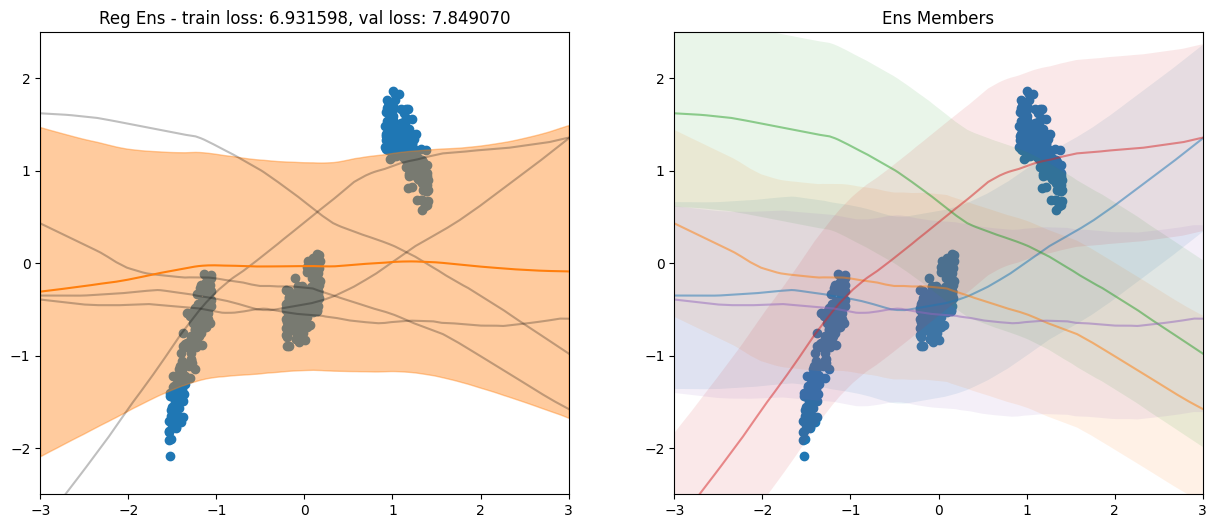

Best val_err
epoch:  11 - ('train loss: 6.72822, val loss: 7.73086, train err: 0.2075, val err: 0.8560, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.72822')
Best val_err
epoch:  12 - ('train loss: 6.55196, val loss: 7.61018, train err: 0.1815, val err: 0.8178, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.55196')
Best val_err
epoch:  13 - ('train loss: 6.39606, val loss: 7.48863, train err: 0.1583, val err: 0.7793, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.39606')
Best val_err
epoch:  14 - ('train loss: 6.26974, val loss: 7.36732, train err: 0.1443, val err: 0.7406, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.26974')
Best val_err
epoch:  15 - ('train loss: 6.15757, val loss: 7.24767, train err: 0.1288, val err: 0.7027, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.15757')
Best val_err
epoch:  16 - ('train loss: 6.06181, val loss: 7.13082, train err: 0.1163, val err: 0.6658, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.06181')
Best val_err
epoch:  1

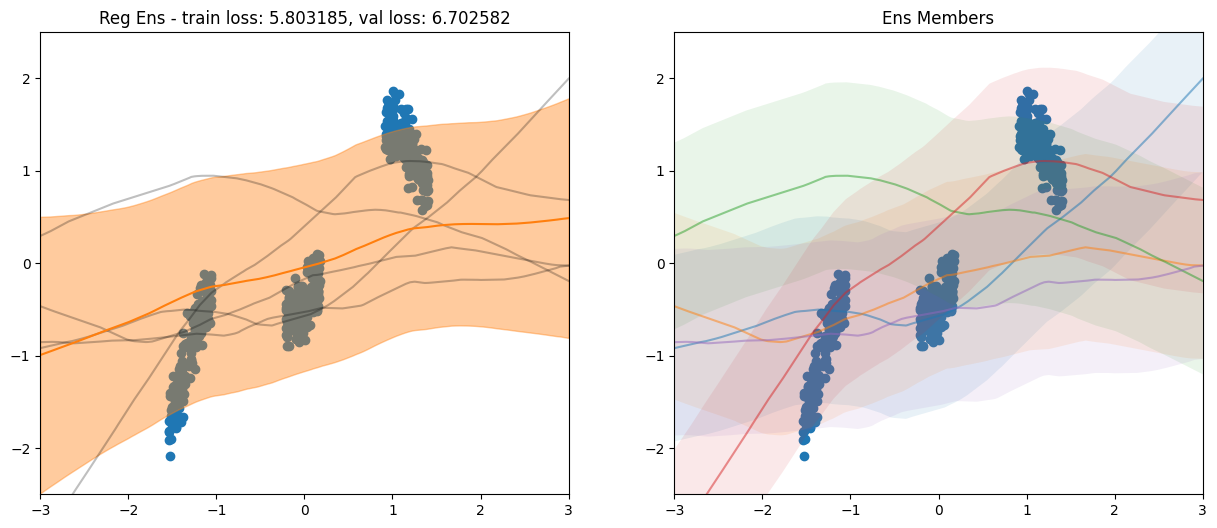

Best val_err
epoch:  21 - ('train loss: 5.75738, val loss: 6.60674, train err: 0.0868, val err: 0.5022, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.75738')
Best val_err
epoch:  22 - ('train loss: 5.71530, val loss: 6.51677, train err: 0.0844, val err: 0.4747, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.71530')
Best val_err
epoch:  23 - ('train loss: 5.67594, val loss: 6.43222, train err: 0.0822, val err: 0.4492, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.67594')
Best val_err
epoch:  24 - ('train loss: 5.63864, val loss: 6.35240, train err: 0.0804, val err: 0.4253, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.63864')
Best val_err
epoch:  25 - ('train loss: 5.60188, val loss: 6.27703, train err: 0.0789, val err: 0.4032, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.60188')
Best val_err
epoch:  26 - ('train loss: 5.56558, val loss: 6.20527, train err: 0.0775, val err: 0.3824, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.56558')
Best val_err
epoch:  2

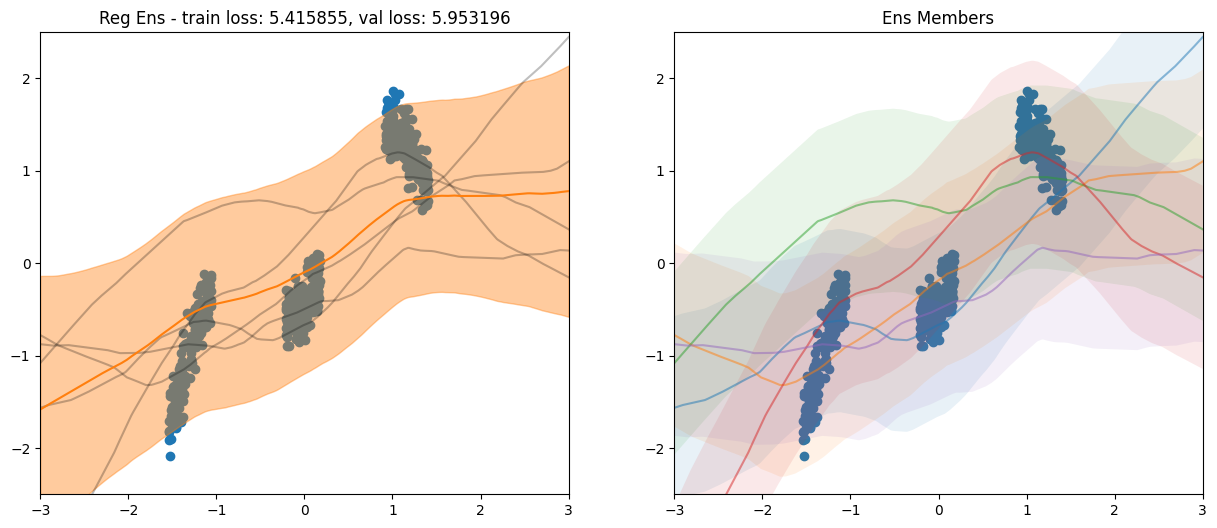

Best val_err
epoch:  31 - ('train loss: 5.37659, val loss: 5.89829, train err: 0.0703, val err: 0.2998, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.37659')
Best val_err
epoch:  32 - ('train loss: 5.33720, val loss: 5.84588, train err: 0.0686, val err: 0.2871, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.33720')
Best val_err
epoch:  33 - ('train loss: 5.29763, val loss: 5.79600, train err: 0.0670, val err: 0.2755, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.29763')
Best val_err
epoch:  34 - ('train loss: 5.25795, val loss: 5.74831, train err: 0.0654, val err: 0.2647, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.25795')
Best val_err
epoch:  35 - ('train loss: 5.21831, val loss: 5.70236, train err: 0.0639, val err: 0.2545, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.21831')
Best val_err
epoch:  36 - ('train loss: 5.17879, val loss: 5.65837, train err: 0.0624, val err: 0.2453, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.17879')
Best val_err
epoch:  3

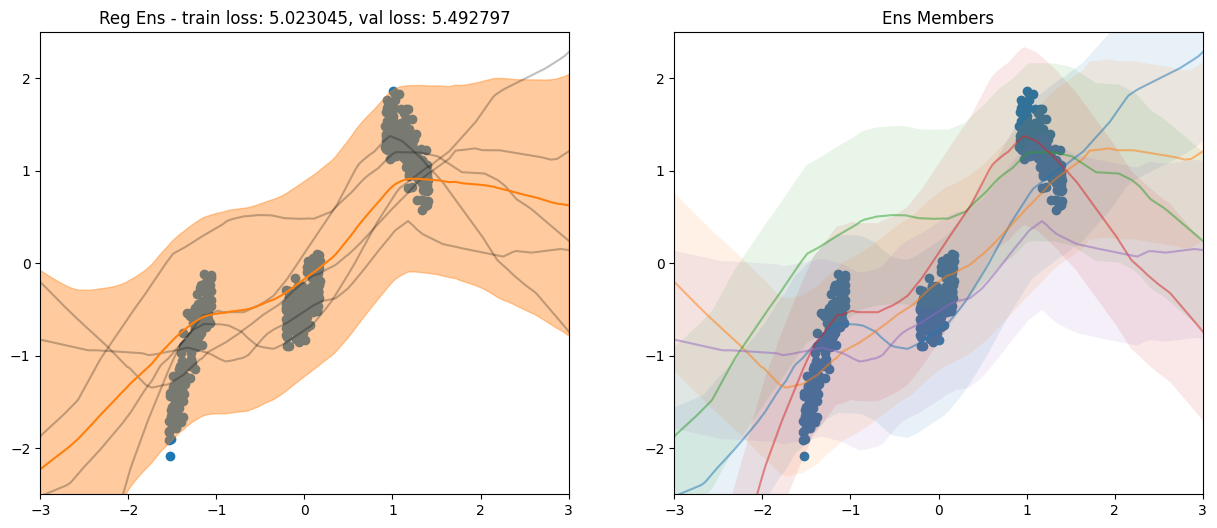

Best val_err
epoch:  41 - ('train loss: 4.98515, val loss: 5.45320, train err: 0.0556, val err: 0.2058, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.98515')
Best val_err
epoch:  42 - ('train loss: 4.94795, val loss: 5.41384, train err: 0.0545, val err: 0.1986, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.94795')
Best val_err
epoch:  43 - ('train loss: 4.91160, val loss: 5.37442, train err: 0.0534, val err: 0.1915, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.91160')
Best val_err
epoch:  44 - ('train loss: 4.87616, val loss: 5.33482, train err: 0.0525, val err: 0.1844, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.87616')
Best val_err
epoch:  45 - ('train loss: 4.84141, val loss: 5.29473, train err: 0.0516, val err: 0.1773, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.84141')
Best val_err
epoch:  46 - ('train loss: 4.80733, val loss: 5.25471, train err: 0.0507, val err: 0.1704, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.80733')
Best val_err
epoch:  4

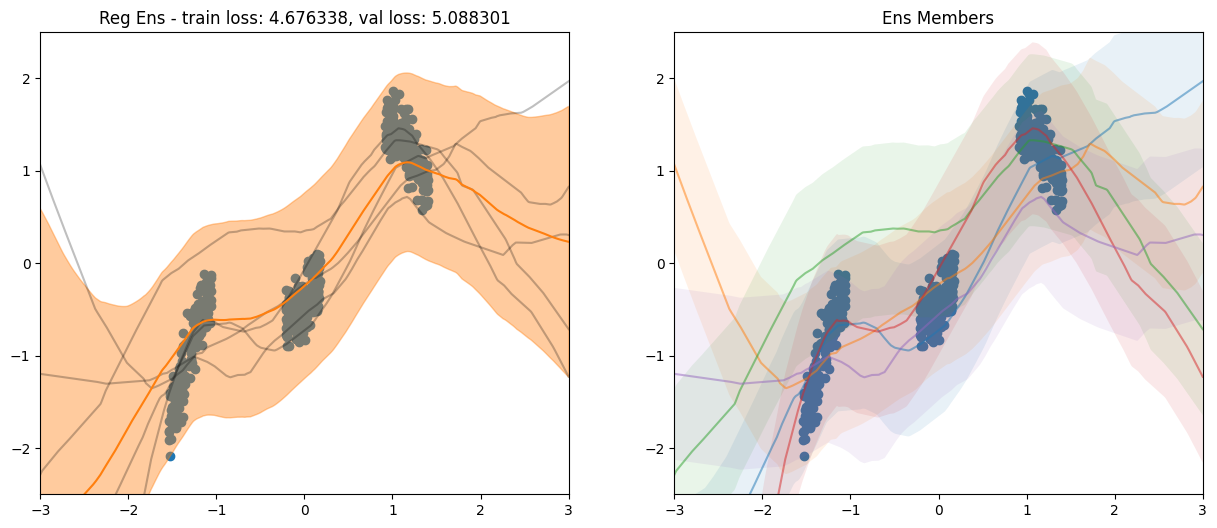

Best val_err
epoch:  51 - ('train loss: 4.64515, val loss: 5.04574, train err: 0.0473, val err: 0.1367, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.64515')
Best val_err
epoch:  52 - ('train loss: 4.61440, val loss: 5.00380, train err: 0.0468, val err: 0.1309, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.61440')
Best val_err
epoch:  53 - ('train loss: 4.58407, val loss: 4.96241, train err: 0.0463, val err: 0.1256, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.58407')
Best val_err
epoch:  54 - ('train loss: 4.55397, val loss: 4.92160, train err: 0.0459, val err: 0.1206, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.55397')
Best val_err
epoch:  55 - ('train loss: 4.52408, val loss: 4.88144, train err: 0.0454, val err: 0.1160, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.52408')
Best val_err
epoch:  56 - ('train loss: 4.49448, val loss: 4.84174, train err: 0.0450, val err: 0.1118, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.49448')
Best val_err
epoch:  5

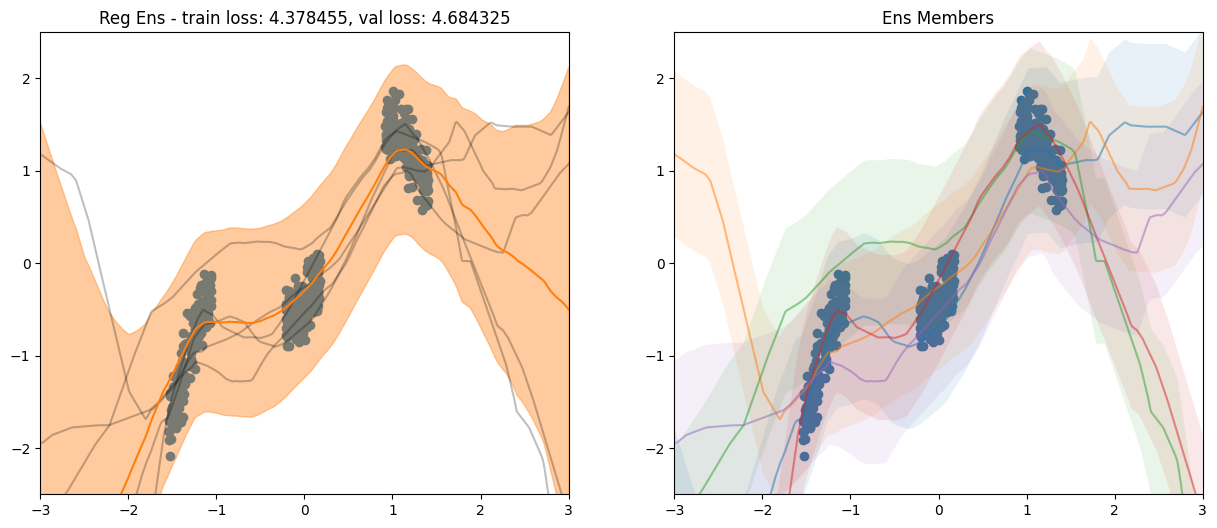

Best val_err
epoch:  61 - ('train loss: 4.35006, val loss: 4.64538, train err: 0.0431, val err: 0.0942, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.35006')
Best val_err
epoch:  62 - ('train loss: 4.32186, val loss: 4.60680, train err: 0.0428, val err: 0.0913, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.32186')
Best val_err
epoch:  63 - ('train loss: 4.29388, val loss: 4.56853, train err: 0.0425, val err: 0.0885, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.29388')
Best val_err
epoch:  64 - ('train loss: 4.26611, val loss: 4.53070, train err: 0.0421, val err: 0.0860, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.26611')
Best val_err
epoch:  65 - ('train loss: 4.23856, val loss: 4.49316, train err: 0.0418, val err: 0.0837, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.23856')
Best val_err
epoch:  66 - ('train loss: 4.21119, val loss: 4.45597, train err: 0.0415, val err: 0.0815, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.21119')
Best val_err
epoch:  6

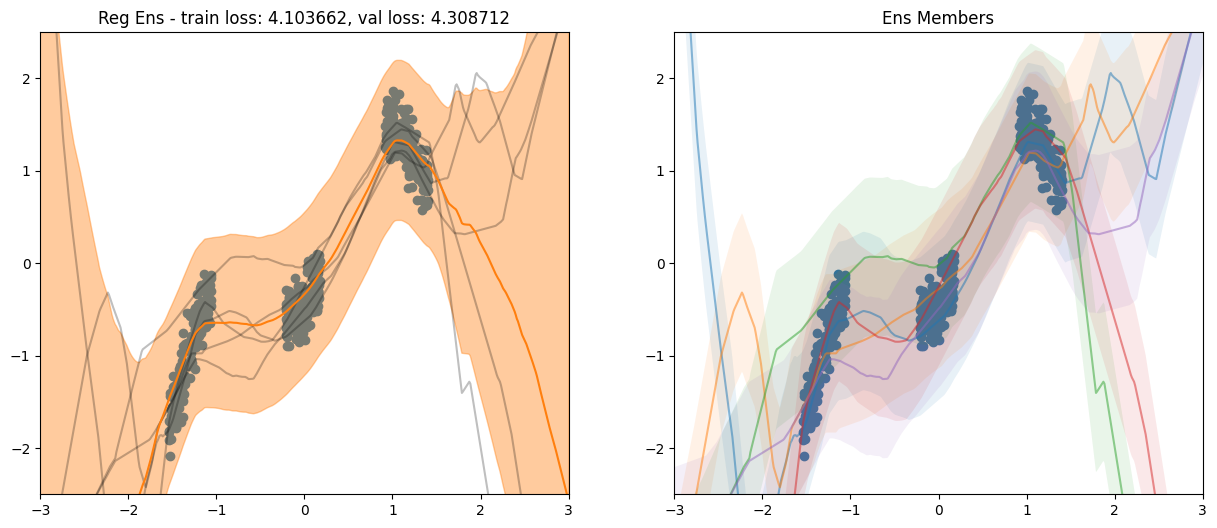

Best val_err
epoch:  71 - ('train loss: 4.07714, val loss: 4.27325, train err: 0.0402, val err: 0.0726, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.07714')
Best val_err
epoch:  72 - ('train loss: 4.05076, val loss: 4.23800, train err: 0.0399, val err: 0.0712, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.05076')
Best val_err
epoch:  73 - ('train loss: 4.02452, val loss: 4.20298, train err: 0.0397, val err: 0.0699, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.02452')
Best val_err
epoch:  74 - ('train loss: 3.99850, val loss: 4.16766, train err: 0.0395, val err: 0.0686, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.99850')
Best val_err
epoch:  75 - ('train loss: 3.97261, val loss: 4.13260, train err: 0.0392, val err: 0.0672, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.97261')
Best val_err
epoch:  76 - ('train loss: 3.94684, val loss: 4.09745, train err: 0.0390, val err: 0.0658, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.94684')
Best val_err
epoch:  7

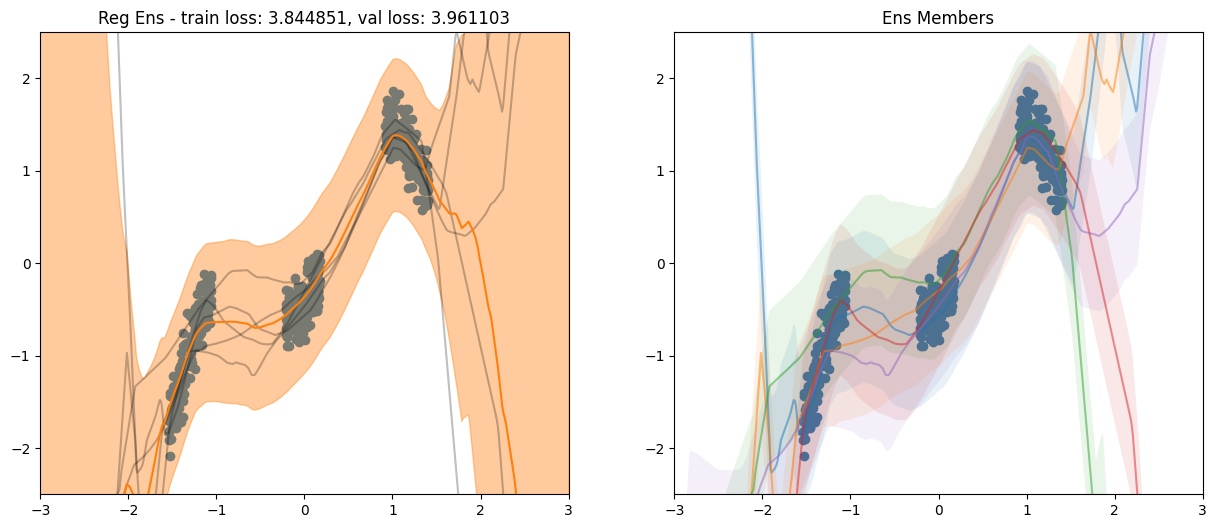

Best val_err
epoch:  81 - ('train loss: 3.81957, val loss: 3.92866, train err: 0.0380, val err: 0.0597, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.81957')
Best val_err
epoch:  82 - ('train loss: 3.79434, val loss: 3.89703, train err: 0.0378, val err: 0.0587, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.79434')
Best val_err
epoch:  83 - ('train loss: 3.76916, val loss: 3.86619, train err: 0.0376, val err: 0.0578, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.76916')
Best val_err
epoch:  84 - ('train loss: 3.74407, val loss: 3.83623, train err: 0.0374, val err: 0.0569, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.74407')
Best val_err
epoch:  85 - ('train loss: 3.71898, val loss: 3.80710, train err: 0.0372, val err: 0.0560, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.71898')
Best val_err
epoch:  86 - ('train loss: 3.69384, val loss: 3.77875, train err: 0.0370, val err: 0.0552, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.69384')
Best val_err
epoch:  8

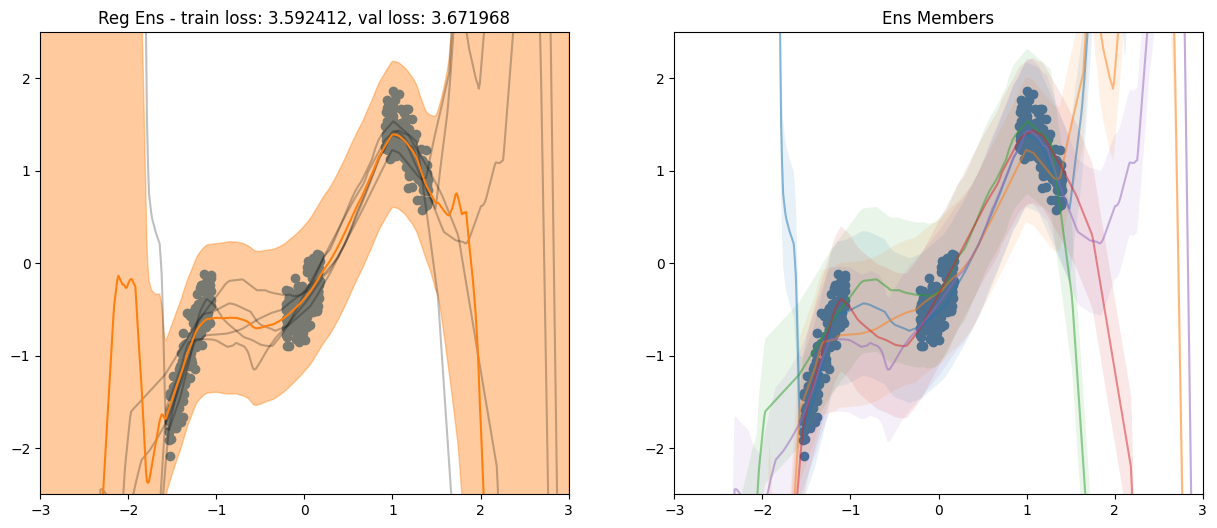

Best val_err
epoch:  91 - ('train loss: 3.56668, val loss: 3.64705, train err: 0.0357, val err: 0.0521, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.56668')
Best val_err
epoch:  92 - ('train loss: 3.54101, val loss: 3.62284, train err: 0.0354, val err: 0.0517, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.54101')
Best val_err
epoch:  93 - ('train loss: 3.51604, val loss: 3.59898, train err: 0.0351, val err: 0.0513, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.51604')
Best val_err
epoch:  94 - ('train loss: 3.49283, val loss: 3.57490, train err: 0.0349, val err: 0.0510, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.49283')
Best val_err
epoch:  95 - ('train loss: 3.47076, val loss: 3.54998, train err: 0.0348, val err: 0.0506, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.47076')
Best val_err
epoch:  96 - ('train loss: 3.44785, val loss: 3.52396, train err: 0.0347, val err: 0.0501, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.44785')
Best val_err
epoch:  9

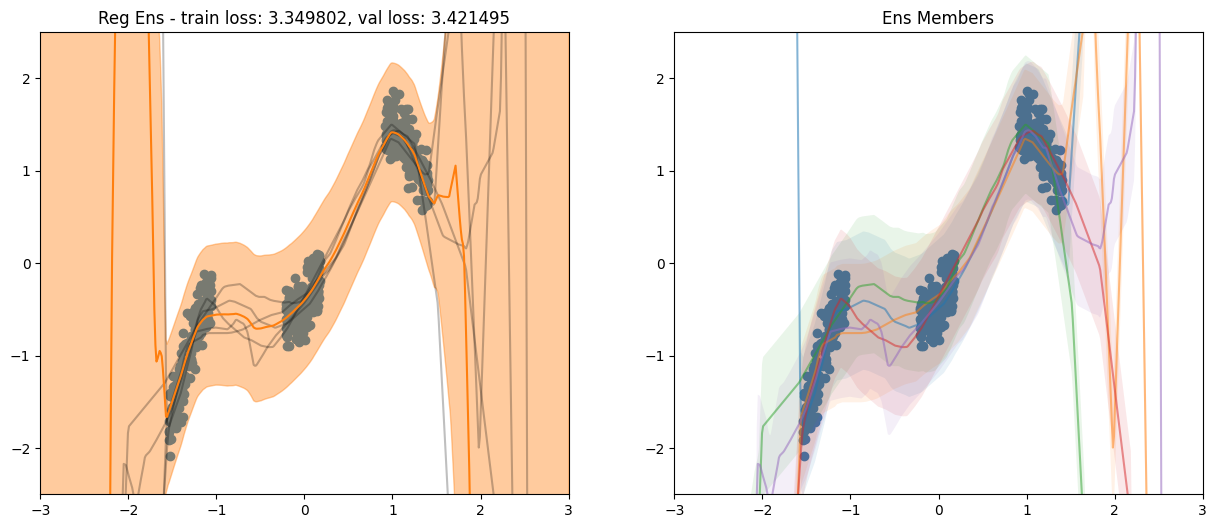

Best val_err


In [47]:
config = get_reg_ens_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_ens_states = []
for i in range(1):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)
    # config.epochs = 100

    ens_model, state = setup_training(config, setup_rng, init_x, init_y)

    if ENS_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            ens_model, state, config, rng, make_Reg_Ens_loss, make_Reg_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': '',
            },
            plot_fn=make_Reg_Ens_plots,
        )

        best_ens_states.append(best_state)

        save_checkpoint(f'dynNN_results/ens_model_{i}', best_ens_states, 1, overwrite=True)

## 2.1 PoN training

In [8]:
NOISE = 'homo'
PRETRAIN = False
FT_EPOCHS = [200]
PRETRAIN_MODEL = "ens_model_0"

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

2022-11-08 18:41:45.782050: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 18:41:46.313010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-08 18:41:46.313078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-08 18:41:46.313086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/200 [00:00<?, ?it/s]

epoch:   1 - ('train loss: 1.87521, val loss: 1.68578, train err: 0.6576, val err: 1.1211, lr: 0.00010, prod_nll: 1.24774', ', members_nll: 1.87521')
Best val_err
epoch:   2 - ('train loss: 1.85081, val loss: 1.69741, train err: 0.6306, val err: 1.1236, lr: 0.00010, prod_nll: 1.23426', ', members_nll: 1.85081')
epoch:   3 - ('train loss: 1.82755, val loss: 1.70805, train err: 0.5756, val err: 1.1241, lr: 0.00010, prod_nll: 1.20684', ', members_nll: 1.82755')
epoch:   4 - ('train loss: 1.81093, val loss: 1.71805, train err: 0.5630, val err: 1.1235, lr: 0.00010, prod_nll: 1.20066', ', members_nll: 1.81093')
epoch:   5 - ('train loss: 1.78569, val loss: 1.72725, train err: 0.5444, val err: 1.1217, lr: 0.00010, prod_nll: 1.19152', ', members_nll: 1.78569')
epoch:   6 - ('train loss: 1.76558, val loss: 1.73556, train err: 0.5294, val err: 1.1188, lr: 0.00010, prod_nll: 1.18418', ', members_nll: 1.76558')
Best val_err
epoch:   7 - ('train loss: 1.74703, val loss: 1.74290, train err: 0.5151, 

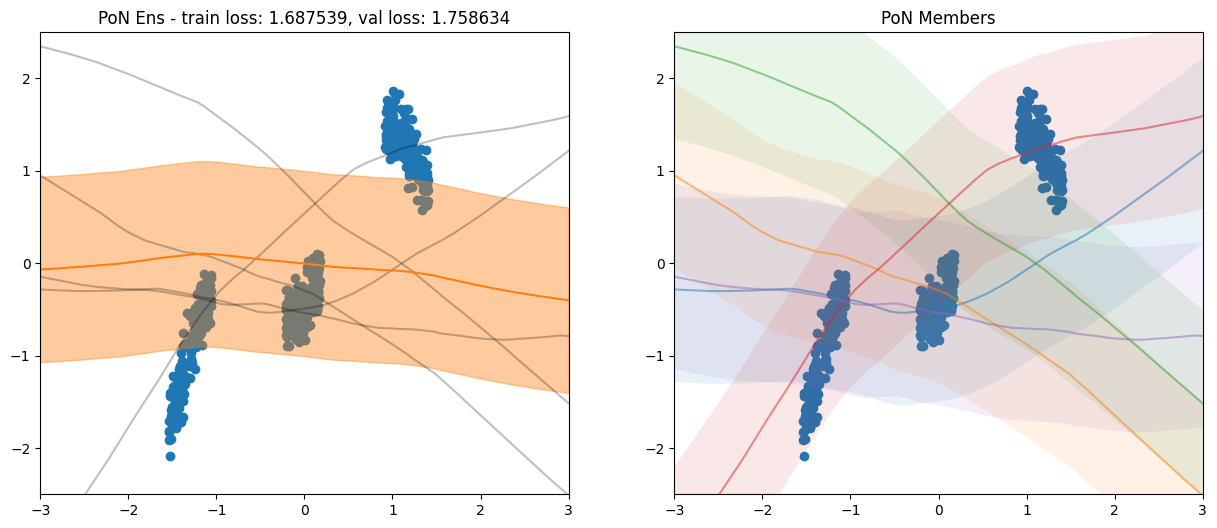

Best val_err
epoch:  11 - ('train loss: 1.66706, val loss: 1.76210, train err: 0.4539, val err: 1.0844, lr: 0.00010, prod_nll: 1.14764', ', members_nll: 1.66706')
Best val_err
epoch:  12 - ('train loss: 1.64657, val loss: 1.76452, train err: 0.4385, val err: 1.0739, lr: 0.00010, prod_nll: 1.14024', ', members_nll: 1.64657')
Best val_err
epoch:  13 - ('train loss: 1.62576, val loss: 1.76586, train err: 0.4233, val err: 1.0621, lr: 0.00010, prod_nll: 1.13292', ', members_nll: 1.62576')
Best val_err
epoch:  14 - ('train loss: 1.60521, val loss: 1.76644, train err: 0.4075, val err: 1.0494, lr: 0.00010, prod_nll: 1.12537', ', members_nll: 1.60521')
Best val_err
epoch:  15 - ('train loss: 1.58459, val loss: 1.76633, train err: 0.3916, val err: 1.0358, lr: 0.00010, prod_nll: 1.11776', ', members_nll: 1.58459')
Best val_err
epoch:  16 - ('train loss: 1.56248, val loss: 1.76531, train err: 0.3744, val err: 1.0211, lr: 0.00010, prod_nll: 1.10953', ', members_nll: 1.56248')
Best val_err
epoch:  1

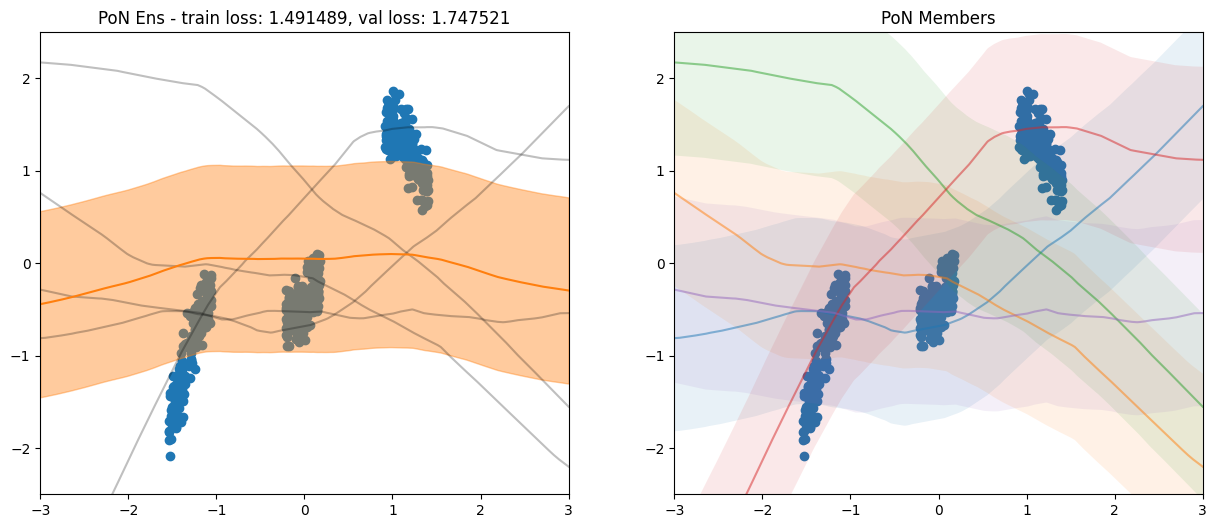

Best val_err
epoch:  21 - ('train loss: 1.47554, val loss: 1.74025, train err: 0.3070, val err: 0.9225, lr: 0.00010, prod_nll: 1.07746', ', members_nll: 1.47554')
Best val_err
epoch:  22 - ('train loss: 1.46028, val loss: 1.73201, train err: 0.2953, val err: 0.8985, lr: 0.00010, prod_nll: 1.07194', ', members_nll: 1.46028')
Best val_err
epoch:  23 - ('train loss: 1.44560, val loss: 1.72286, train err: 0.2842, val err: 0.8736, lr: 0.00010, prod_nll: 1.06666', ', members_nll: 1.44560')
Best val_err
epoch:  24 - ('train loss: 1.43160, val loss: 1.71286, train err: 0.2736, val err: 0.8480, lr: 0.00010, prod_nll: 1.06165', ', members_nll: 1.43160')
Best val_err
epoch:  25 - ('train loss: 1.41817, val loss: 1.70207, train err: 0.2635, val err: 0.8218, lr: 0.00010, prod_nll: 1.05686', ', members_nll: 1.41817')
Best val_err
epoch:  26 - ('train loss: 1.40533, val loss: 1.69053, train err: 0.2539, val err: 0.7950, lr: 0.00010, prod_nll: 1.05229', ', members_nll: 1.40533')
Best val_err
epoch:  2

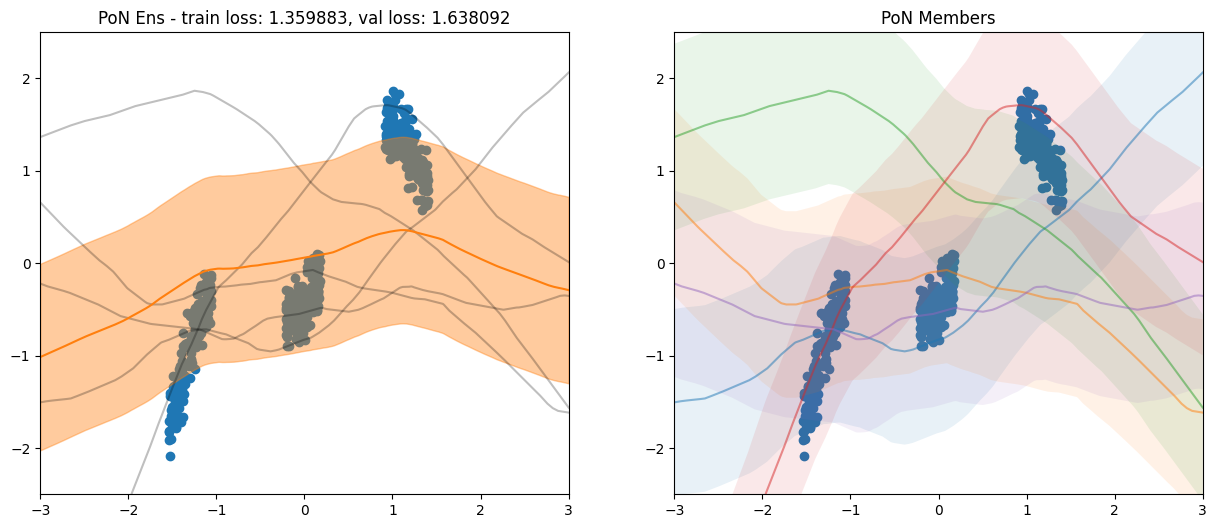

Best val_err
epoch:  31 - ('train loss: 1.34983, val loss: 1.62396, train err: 0.2132, val err: 0.6576, lr: 0.00010, prod_nll: 1.03277', ', members_nll: 1.34983')
Best val_err
epoch:  32 - ('train loss: 1.34019, val loss: 1.60959, train err: 0.2062, val err: 0.6301, lr: 0.00010, prod_nll: 1.02941', ', members_nll: 1.34019')
Best val_err
epoch:  33 - ('train loss: 1.33082, val loss: 1.59509, train err: 0.1995, val err: 0.6027, lr: 0.00010, prod_nll: 1.02615', ', members_nll: 1.33082')
Best val_err
epoch:  34 - ('train loss: 1.32080, val loss: 1.58079, train err: 0.1923, val err: 0.5760, lr: 0.00010, prod_nll: 1.02261', ', members_nll: 1.32080')
Best val_err
epoch:  35 - ('train loss: 1.31460, val loss: 1.56703, train err: 0.1920, val err: 0.5510, lr: 0.00010, prod_nll: 1.02248', ', members_nll: 1.31460')
Best val_err
epoch:  36 - ('train loss: 1.30677, val loss: 1.55324, train err: 0.1864, val err: 0.5263, lr: 0.00010, prod_nll: 1.01970', ', members_nll: 1.30677')
Best val_err
epoch:  3

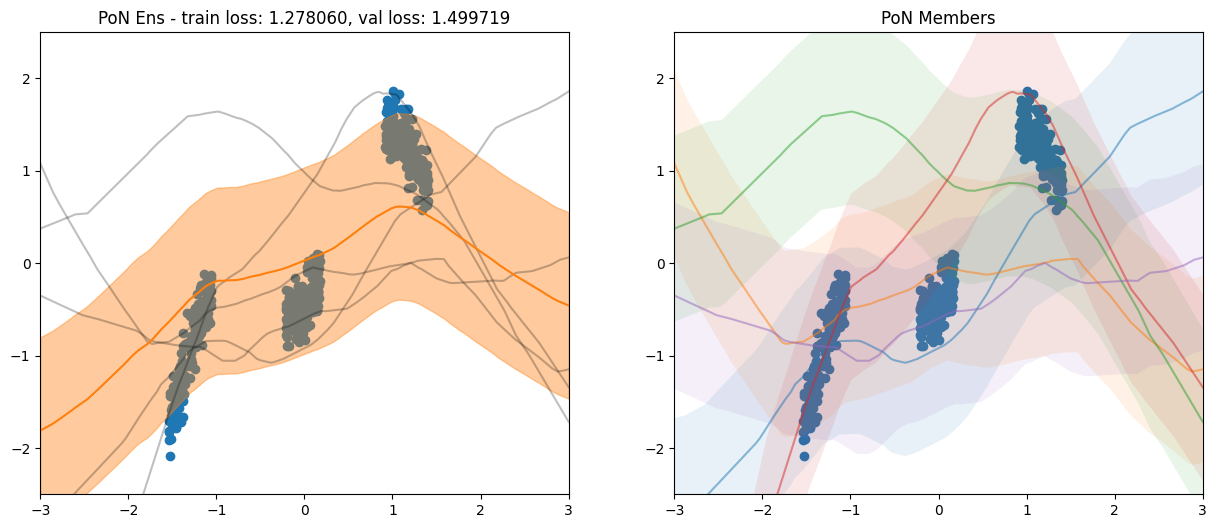

Best val_err
epoch:  41 - ('train loss: 1.27159, val loss: 1.48694, train err: 0.1617, val err: 0.4154, lr: 0.00010, prod_nll: 1.00718', ', members_nll: 1.27159')
Best val_err
epoch:  42 - ('train loss: 1.26537, val loss: 1.47422, train err: 0.1574, val err: 0.3959, lr: 0.00010, prod_nll: 1.00494', ', members_nll: 1.26537')
Best val_err
epoch:  43 - ('train loss: 1.25941, val loss: 1.46141, train err: 0.1533, val err: 0.3770, lr: 0.00010, prod_nll: 1.00279', ', members_nll: 1.25941')
Best val_err
epoch:  44 - ('train loss: 1.25368, val loss: 1.44813, train err: 0.1494, val err: 0.3587, lr: 0.00010, prod_nll: 1.00072', ', members_nll: 1.25368')
Best val_err
epoch:  45 - ('train loss: 1.24816, val loss: 1.43453, train err: 0.1457, val err: 0.3409, lr: 0.00010, prod_nll: 0.99872', ', members_nll: 1.24816')
Best val_err
epoch:  46 - ('train loss: 1.24287, val loss: 1.42116, train err: 0.1422, val err: 0.3238, lr: 0.00010, prod_nll: 0.99680', ', members_nll: 1.24287')
Best val_err
epoch:  4

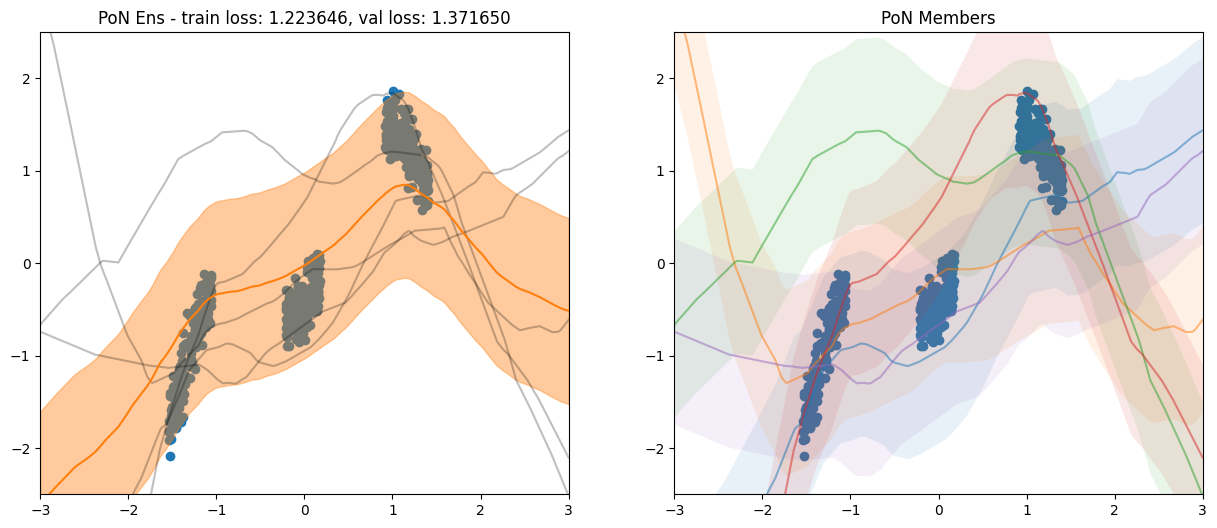

Best val_err
epoch:  51 - ('train loss: 1.21925, val loss: 1.36047, train err: 0.1270, val err: 0.2506, lr: 0.00010, prod_nll: 0.98817', ', members_nll: 1.21925')
Best val_err
epoch:  52 - ('train loss: 1.21501, val loss: 1.34957, train err: 0.1243, val err: 0.2383, lr: 0.00010, prod_nll: 0.98660', ', members_nll: 1.21501')
Best val_err
epoch:  53 - ('train loss: 1.21092, val loss: 1.33911, train err: 0.1218, val err: 0.2269, lr: 0.00010, prod_nll: 0.98509', ', members_nll: 1.21092')
Best val_err
epoch:  54 - ('train loss: 1.20697, val loss: 1.32922, train err: 0.1195, val err: 0.2164, lr: 0.00010, prod_nll: 0.98366', ', members_nll: 1.20697')
Best val_err
epoch:  55 - ('train loss: 1.20313, val loss: 1.31979, train err: 0.1173, val err: 0.2068, lr: 0.00010, prod_nll: 0.98227', ', members_nll: 1.20313')
Best val_err
epoch:  56 - ('train loss: 1.19942, val loss: 1.31070, train err: 0.1151, val err: 0.1979, lr: 0.00010, prod_nll: 0.98091', ', members_nll: 1.19942')
Best val_err
epoch:  5

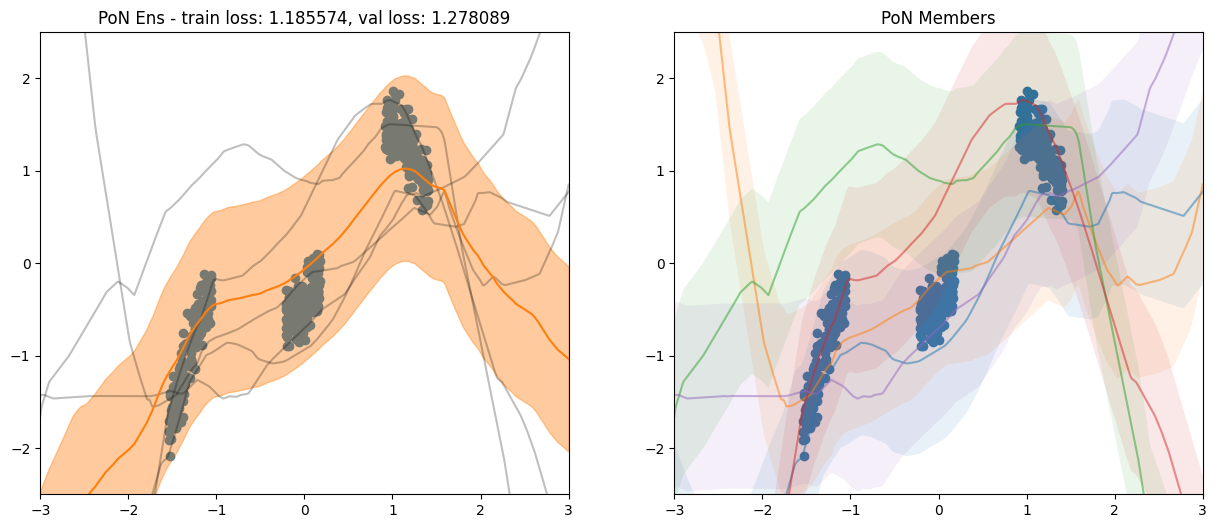

Best val_err
epoch:  61 - ('train loss: 1.18233, val loss: 1.27087, train err: 0.1059, val err: 0.1647, lr: 0.00010, prod_nll: 0.97468', ', members_nll: 1.18233')
Best val_err
epoch:  62 - ('train loss: 1.17916, val loss: 1.26398, train err: 0.1044, val err: 0.1599, lr: 0.00010, prod_nll: 0.97354', ', members_nll: 1.17916')
Best val_err
epoch:  63 - ('train loss: 1.17606, val loss: 1.25737, train err: 0.1029, val err: 0.1556, lr: 0.00010, prod_nll: 0.97243', ', members_nll: 1.17606')
Best val_err
epoch:  64 - ('train loss: 1.17302, val loss: 1.25106, train err: 0.1015, val err: 0.1518, lr: 0.00010, prod_nll: 0.97136', ', members_nll: 1.17302')
Best val_err
epoch:  65 - ('train loss: 1.17005, val loss: 1.24499, train err: 0.1001, val err: 0.1484, lr: 0.00010, prod_nll: 0.97031', ', members_nll: 1.17005')
Best val_err
epoch:  66 - ('train loss: 1.16715, val loss: 1.23909, train err: 0.0989, val err: 0.1452, lr: 0.00010, prod_nll: 0.96928', ', members_nll: 1.16715')
Best val_err
epoch:  6

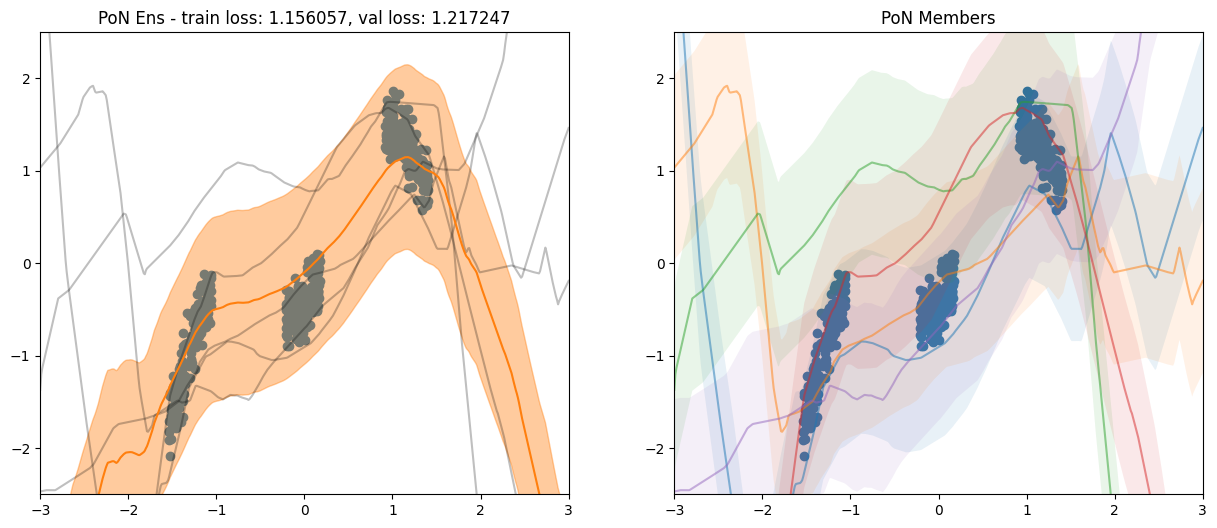

Best val_err
epoch:  71 - ('train loss: 1.15341, val loss: 1.21219, train err: 0.0932, val err: 0.1331, lr: 0.00010, prod_nll: 0.96442', ', members_nll: 1.15341')
Best val_err
epoch:  72 - ('train loss: 1.15080, val loss: 1.20727, train err: 0.0922, val err: 0.1312, lr: 0.00010, prod_nll: 0.96348', ', members_nll: 1.15080')
Best val_err
epoch:  73 - ('train loss: 1.14823, val loss: 1.20250, train err: 0.0913, val err: 0.1295, lr: 0.00010, prod_nll: 0.96256', ', members_nll: 1.14823')
Best val_err
epoch:  74 - ('train loss: 1.14569, val loss: 1.19787, train err: 0.0903, val err: 0.1278, lr: 0.00010, prod_nll: 0.96165', ', members_nll: 1.14569')
Best val_err
epoch:  75 - ('train loss: 1.14319, val loss: 1.19335, train err: 0.0894, val err: 0.1262, lr: 0.00010, prod_nll: 0.96075', ', members_nll: 1.14319')
Best val_err
epoch:  76 - ('train loss: 1.14073, val loss: 1.18896, train err: 0.0886, val err: 0.1247, lr: 0.00010, prod_nll: 0.95986', ', members_nll: 1.14073')
Best val_err
epoch:  7

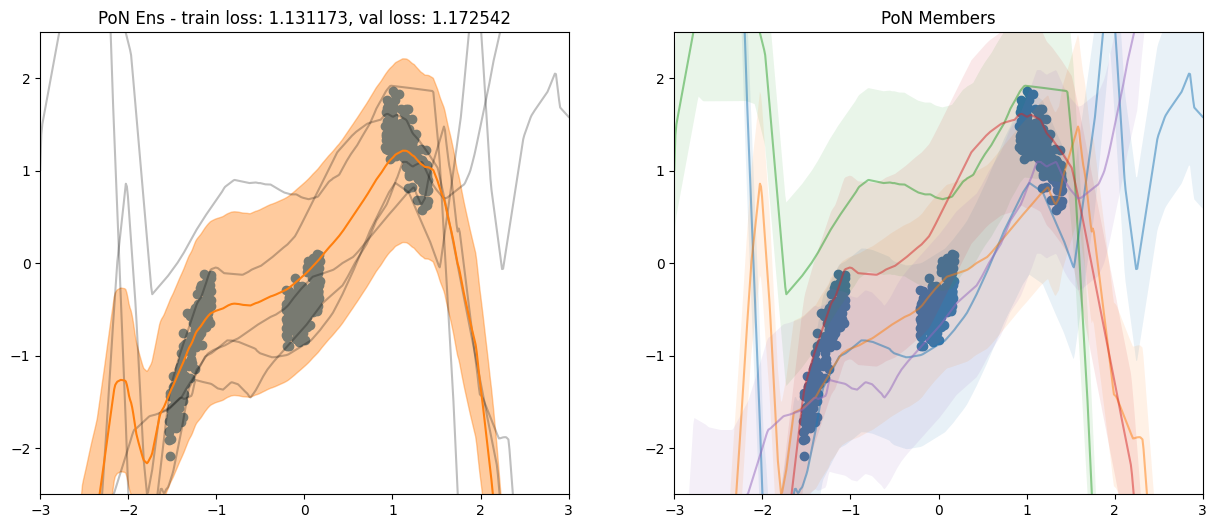

Best val_err
epoch:  81 - ('train loss: 1.12885, val loss: 1.16874, train err: 0.0844, val err: 0.1184, lr: 0.00010, prod_nll: 0.95544', ', members_nll: 1.12885')
Best val_err
epoch:  82 - ('train loss: 1.12656, val loss: 1.16509, train err: 0.0837, val err: 0.1174, lr: 0.00010, prod_nll: 0.95457', ', members_nll: 1.12656')
Best val_err
epoch:  83 - ('train loss: 1.12430, val loss: 1.16155, train err: 0.0829, val err: 0.1164, lr: 0.00010, prod_nll: 0.95372', ', members_nll: 1.12430')
Best val_err
epoch:  84 - ('train loss: 1.12206, val loss: 1.15814, train err: 0.0822, val err: 0.1155, lr: 0.00010, prod_nll: 0.95287', ', members_nll: 1.12206')
Best val_err
epoch:  85 - ('train loss: 1.11984, val loss: 1.15484, train err: 0.0815, val err: 0.1146, lr: 0.00010, prod_nll: 0.95202', ', members_nll: 1.11984')
Best val_err
epoch:  86 - ('train loss: 1.11764, val loss: 1.15164, train err: 0.0808, val err: 0.1138, lr: 0.00010, prod_nll: 0.95117', ', members_nll: 1.11764')
Best val_err
epoch:  8

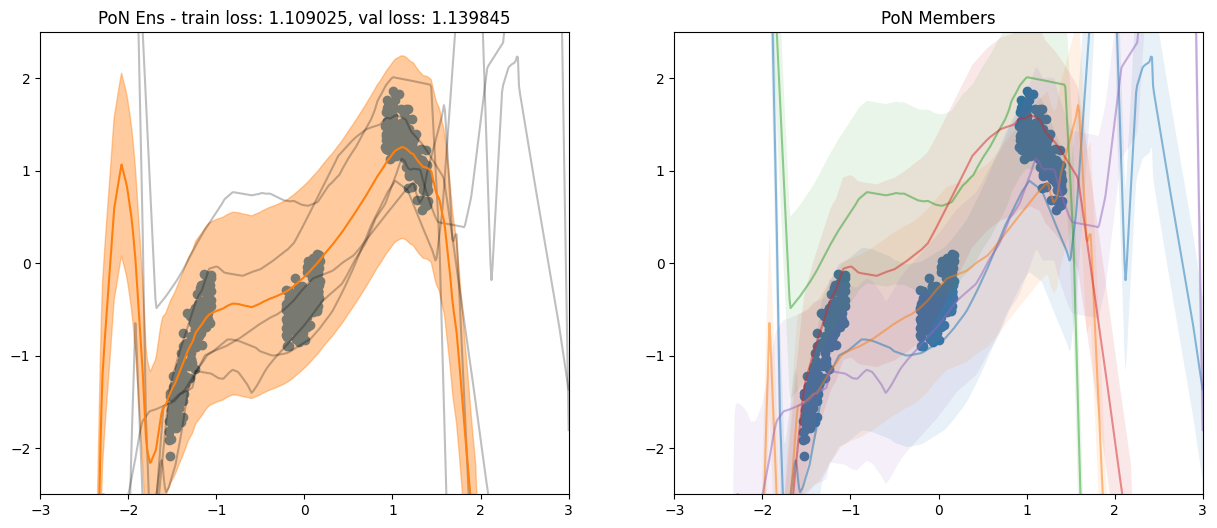

Best val_err
epoch:  91 - ('train loss: 1.10692, val loss: 1.13710, train err: 0.0776, val err: 0.1102, lr: 0.00010, prod_nll: 0.94695', ', members_nll: 1.10692')
Best val_err
epoch:  92 - ('train loss: 1.10482, val loss: 1.13441, train err: 0.0770, val err: 0.1095, lr: 0.00010, prod_nll: 0.94612', ', members_nll: 1.10482')
Best val_err
epoch:  93 - ('train loss: 1.10274, val loss: 1.13179, train err: 0.0764, val err: 0.1088, lr: 0.00010, prod_nll: 0.94528', ', members_nll: 1.10274')
Best val_err
epoch:  94 - ('train loss: 1.10068, val loss: 1.12922, train err: 0.0758, val err: 0.1082, lr: 0.00010, prod_nll: 0.94445', ', members_nll: 1.10068')
Best val_err
epoch:  95 - ('train loss: 1.09863, val loss: 1.12670, train err: 0.0752, val err: 0.1076, lr: 0.00010, prod_nll: 0.94361', ', members_nll: 1.09863')
Best val_err
epoch:  96 - ('train loss: 1.09660, val loss: 1.12424, train err: 0.0746, val err: 0.1069, lr: 0.00010, prod_nll: 0.94278', ', members_nll: 1.09660')
Best val_err
epoch:  9

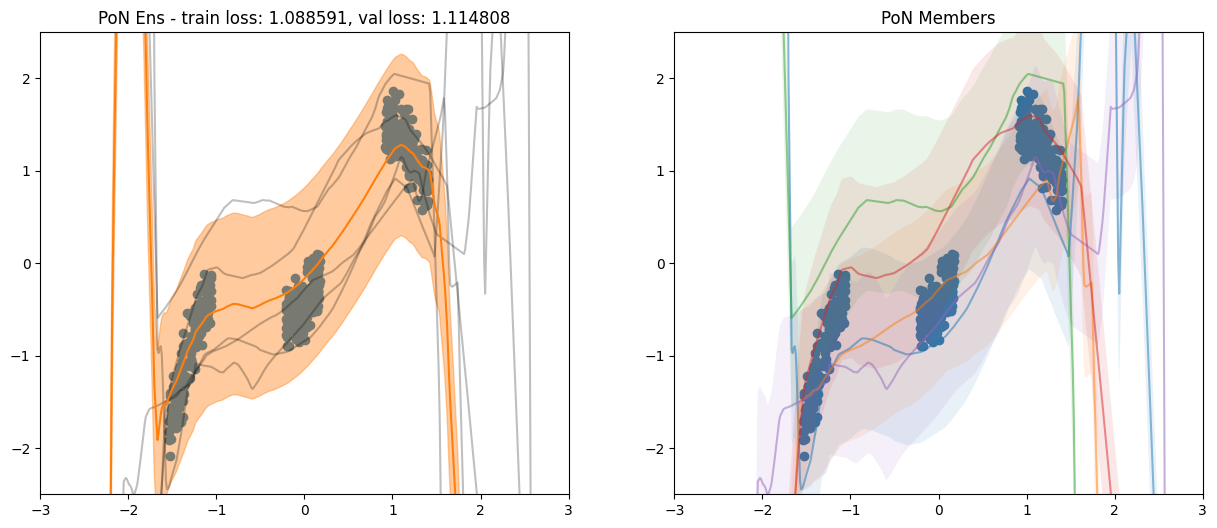

Best val_err
epoch: 101 - ('train loss: 1.08662, val loss: 1.11253, train err: 0.0718, val err: 0.1038, lr: 0.00010, prod_nll: 0.93862', ', members_nll: 1.08662')
Best val_err
epoch: 102 - ('train loss: 1.08466, val loss: 1.11027, train err: 0.0713, val err: 0.1032, lr: 0.00010, prod_nll: 0.93779', ', members_nll: 1.08466')
Best val_err
epoch: 103 - ('train loss: 1.08271, val loss: 1.10802, train err: 0.0708, val err: 0.1027, lr: 0.00010, prod_nll: 0.93696', ', members_nll: 1.08271')
Best val_err
epoch: 104 - ('train loss: 1.08076, val loss: 1.10578, train err: 0.0703, val err: 0.1021, lr: 0.00010, prod_nll: 0.93613', ', members_nll: 1.08076')
Best val_err
epoch: 105 - ('train loss: 1.07883, val loss: 1.10357, train err: 0.0698, val err: 0.1015, lr: 0.00010, prod_nll: 0.93530', ', members_nll: 1.07883')
Best val_err
epoch: 106 - ('train loss: 1.07691, val loss: 1.10138, train err: 0.0693, val err: 0.1009, lr: 0.00010, prod_nll: 0.93447', ', members_nll: 1.07691')
Best val_err
epoch: 10

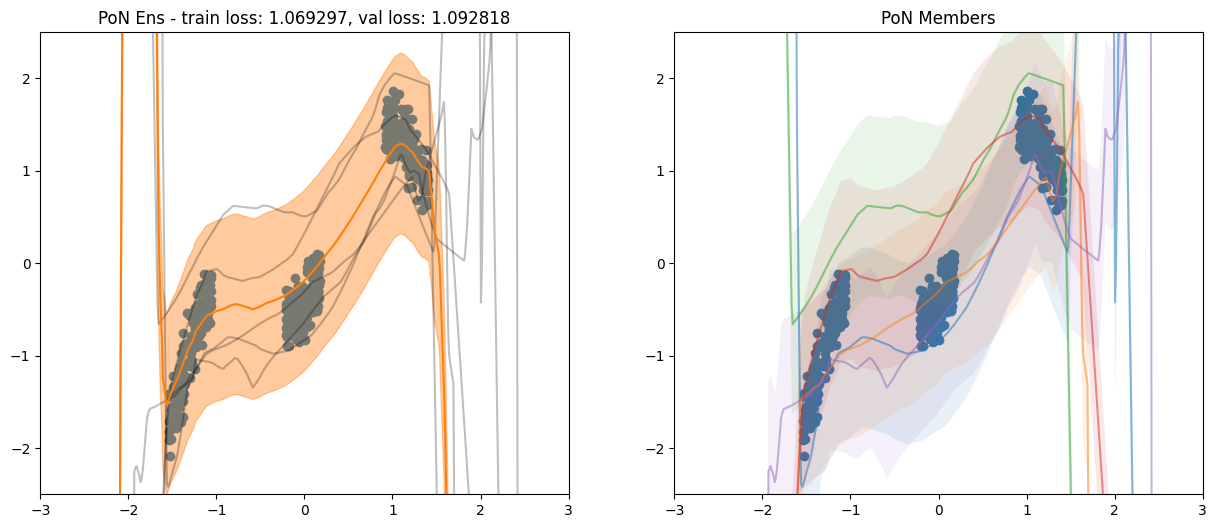

Best val_err
epoch: 111 - ('train loss: 1.06741, val loss: 1.09072, train err: 0.0668, val err: 0.0981, lr: 0.00010, prod_nll: 0.93032', ', members_nll: 1.06741')
Best val_err
epoch: 112 - ('train loss: 1.06553, val loss: 1.08864, train err: 0.0664, val err: 0.0976, lr: 0.00010, prod_nll: 0.92948', ', members_nll: 1.06553')
Best val_err
epoch: 113 - ('train loss: 1.06365, val loss: 1.08657, train err: 0.0659, val err: 0.0970, lr: 0.00010, prod_nll: 0.92864', ', members_nll: 1.06365')
Best val_err
epoch: 114 - ('train loss: 1.06177, val loss: 1.08451, train err: 0.0654, val err: 0.0965, lr: 0.00010, prod_nll: 0.92780', ', members_nll: 1.06177')
Best val_err
epoch: 115 - ('train loss: 1.05990, val loss: 1.08246, train err: 0.0650, val err: 0.0959, lr: 0.00010, prod_nll: 0.92696', ', members_nll: 1.05990')
Best val_err
epoch: 116 - ('train loss: 1.05803, val loss: 1.08042, train err: 0.0645, val err: 0.0954, lr: 0.00010, prod_nll: 0.92612', ', members_nll: 1.05803')
Best val_err
epoch: 11

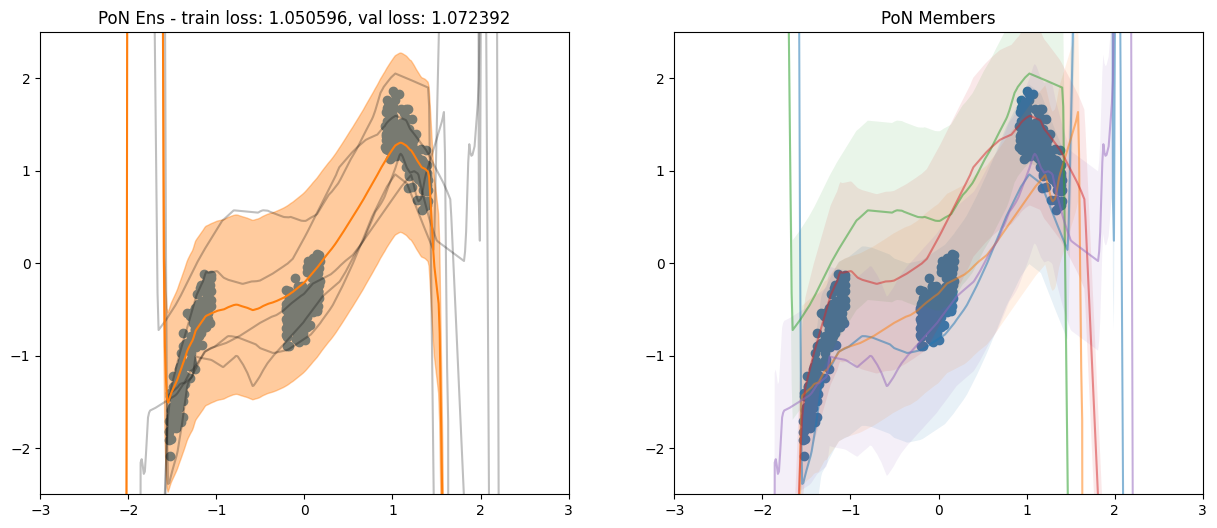

Best val_err
epoch: 121 - ('train loss: 1.04875, val loss: 1.07041, train err: 0.0622, val err: 0.0927, lr: 0.00010, prod_nll: 0.92186', ', members_nll: 1.04875')
Best val_err
epoch: 122 - ('train loss: 1.04690, val loss: 1.06844, train err: 0.0617, val err: 0.0922, lr: 0.00010, prod_nll: 0.92100', ', members_nll: 1.04690')
Best val_err
epoch: 123 - ('train loss: 1.04507, val loss: 1.06647, train err: 0.0613, val err: 0.0917, lr: 0.00010, prod_nll: 0.92015', ', members_nll: 1.04507')
Best val_err
epoch: 124 - ('train loss: 1.04325, val loss: 1.06452, train err: 0.0608, val err: 0.0911, lr: 0.00010, prod_nll: 0.91929', ', members_nll: 1.04325')
Best val_err
epoch: 125 - ('train loss: 1.04144, val loss: 1.06258, train err: 0.0604, val err: 0.0906, lr: 0.00010, prod_nll: 0.91844', ', members_nll: 1.04144')
Best val_err
epoch: 126 - ('train loss: 1.03965, val loss: 1.06064, train err: 0.0600, val err: 0.0901, lr: 0.00010, prod_nll: 0.91759', ', members_nll: 1.03965')
Best val_err
epoch: 12

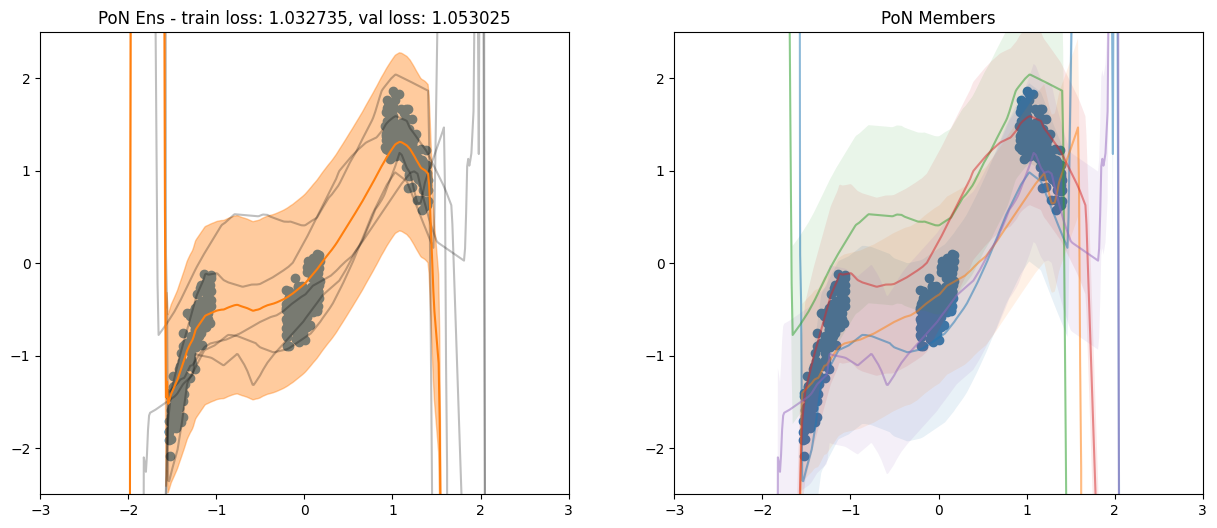

Best val_err
epoch: 131 - ('train loss: 1.03106, val loss: 1.05115, train err: 0.0582, val err: 0.0874, lr: 0.00010, prod_nll: 0.91346', ', members_nll: 1.03106')
Best val_err
epoch: 132 - ('train loss: 1.02940, val loss: 1.04929, train err: 0.0578, val err: 0.0869, lr: 0.00010, prod_nll: 0.91265', ', members_nll: 1.02940')
Best val_err
epoch: 133 - ('train loss: 1.02774, val loss: 1.04744, train err: 0.0575, val err: 0.0864, lr: 0.00010, prod_nll: 0.91185', ', members_nll: 1.02774')
Best val_err
epoch: 134 - ('train loss: 1.02609, val loss: 1.04559, train err: 0.0573, val err: 0.0858, lr: 0.00010, prod_nll: 0.91105', ', members_nll: 1.02609')
Best val_err
epoch: 135 - ('train loss: 1.02443, val loss: 1.04376, train err: 0.0570, val err: 0.0853, lr: 0.00010, prod_nll: 0.91025', ', members_nll: 1.02443')
Best val_err
epoch: 136 - ('train loss: 1.02277, val loss: 1.04193, train err: 0.0567, val err: 0.0848, lr: 0.00010, prod_nll: 0.90944', ', members_nll: 1.02277')
Best val_err
epoch: 13

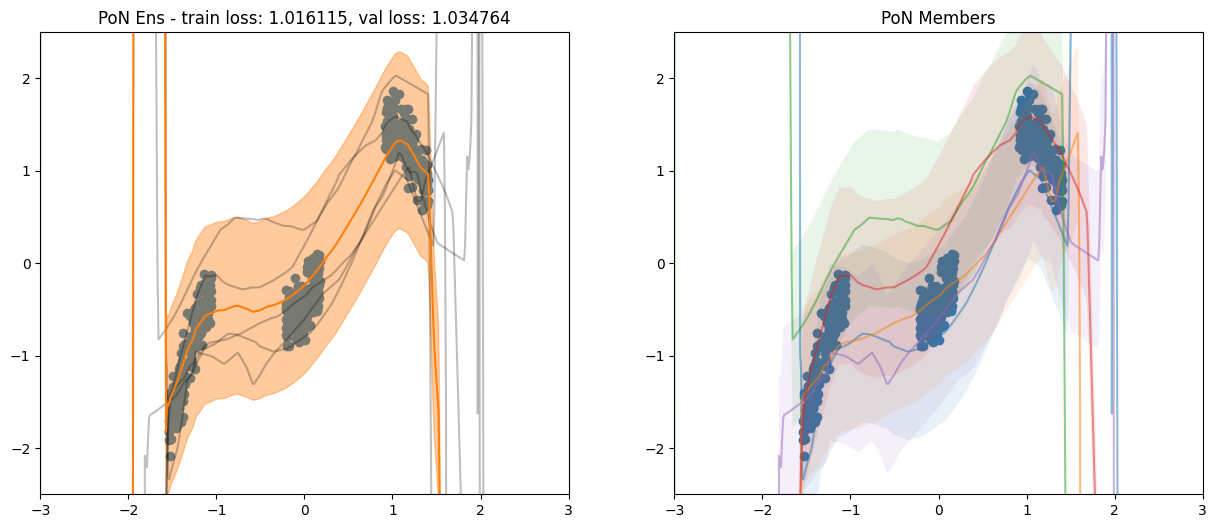

Best val_err
epoch: 141 - ('train loss: 1.01446, val loss: 1.03301, train err: 0.0553, val err: 0.0823, lr: 0.00010, prod_nll: 0.90541', ', members_nll: 1.01446')
Best val_err
epoch: 142 - ('train loss: 1.01281, val loss: 1.03128, train err: 0.0550, val err: 0.0818, lr: 0.00010, prod_nll: 0.90461', ', members_nll: 1.01281')
Best val_err
epoch: 143 - ('train loss: 1.01118, val loss: 1.02956, train err: 0.0548, val err: 0.0813, lr: 0.00010, prod_nll: 0.90380', ', members_nll: 1.01118')
Best val_err
epoch: 144 - ('train loss: 1.00955, val loss: 1.02786, train err: 0.0545, val err: 0.0809, lr: 0.00010, prod_nll: 0.90300', ', members_nll: 1.00955')
Best val_err
epoch: 145 - ('train loss: 1.00794, val loss: 1.02618, train err: 0.0543, val err: 0.0805, lr: 0.00010, prod_nll: 0.90220', ', members_nll: 1.00794')
Best val_err
epoch: 146 - ('train loss: 1.00633, val loss: 1.02450, train err: 0.0540, val err: 0.0801, lr: 0.00010, prod_nll: 0.90140', ', members_nll: 1.00633')
Best val_err
epoch: 14

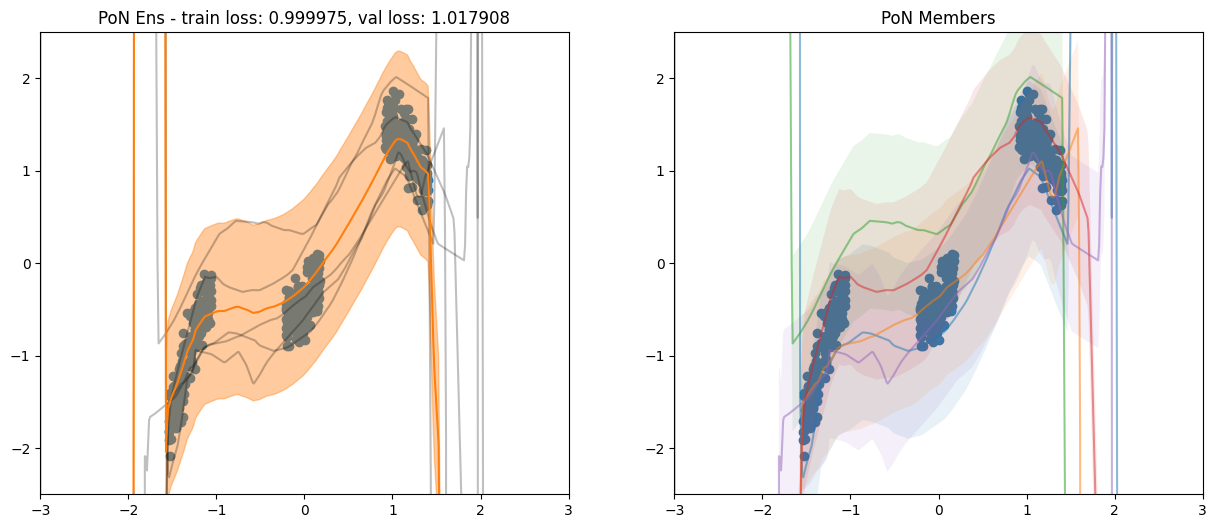

Best val_err
epoch: 151 - ('train loss: 0.99840, val loss: 1.01627, train err: 0.0529, val err: 0.0784, lr: 0.00010, prod_nll: 0.89739', ', members_nll: 0.99840')
Best val_err
epoch: 152 - ('train loss: 0.99682, val loss: 1.01464, train err: 0.0526, val err: 0.0780, lr: 0.00010, prod_nll: 0.89658', ', members_nll: 0.99682')
Best val_err
epoch: 153 - ('train loss: 0.99525, val loss: 1.01302, train err: 0.0524, val err: 0.0777, lr: 0.00010, prod_nll: 0.89577', ', members_nll: 0.99525')
Best val_err
epoch: 154 - ('train loss: 0.99368, val loss: 1.01139, train err: 0.0522, val err: 0.0774, lr: 0.00010, prod_nll: 0.89496', ', members_nll: 0.99368')
Best val_err
epoch: 155 - ('train loss: 0.99211, val loss: 1.00978, train err: 0.0519, val err: 0.0771, lr: 0.00010, prod_nll: 0.89414', ', members_nll: 0.99211')
Best val_err
epoch: 156 - ('train loss: 0.99055, val loss: 1.00817, train err: 0.0517, val err: 0.0768, lr: 0.00010, prod_nll: 0.89333', ', members_nll: 0.99055')
Best val_err
epoch: 15

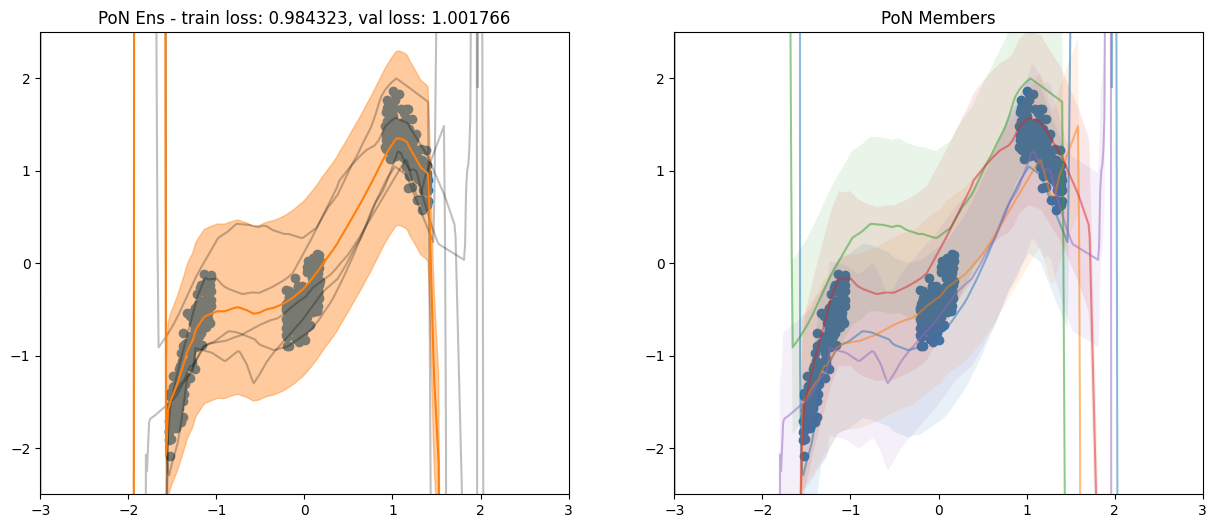

Best val_err
epoch: 161 - ('train loss: 0.98278, val loss: 1.00018, train err: 0.0506, val err: 0.0753, lr: 0.00010, prod_nll: 0.88923', ', members_nll: 0.98278')
Best val_err
epoch: 162 - ('train loss: 0.98124, val loss: 0.99860, train err: 0.0504, val err: 0.0750, lr: 0.00010, prod_nll: 0.88841', ', members_nll: 0.98124')
Best val_err
epoch: 163 - ('train loss: 0.97971, val loss: 0.99703, train err: 0.0502, val err: 0.0747, lr: 0.00010, prod_nll: 0.88760', ', members_nll: 0.97971')
Best val_err
epoch: 164 - ('train loss: 0.97819, val loss: 0.99546, train err: 0.0500, val err: 0.0744, lr: 0.00010, prod_nll: 0.88678', ', members_nll: 0.97819')
Best val_err
epoch: 165 - ('train loss: 0.97667, val loss: 0.99391, train err: 0.0498, val err: 0.0742, lr: 0.00010, prod_nll: 0.88596', ', members_nll: 0.97667')
Best val_err
epoch: 166 - ('train loss: 0.97515, val loss: 0.99236, train err: 0.0496, val err: 0.0739, lr: 0.00010, prod_nll: 0.88514', ', members_nll: 0.97515')
Best val_err
epoch: 16

Best val_err
epoch: 171 - ('train loss: 0.96764, val loss: 0.98469, train err: 0.0486, val err: 0.0725, lr: 0.00010, prod_nll: 0.88106', ', members_nll: 0.96764')
Best val_err
epoch: 172 - ('train loss: 0.96615, val loss: 0.98318, train err: 0.0484, val err: 0.0722, lr: 0.00010, prod_nll: 0.88024', ', members_nll: 0.96615')
Best val_err
epoch: 173 - ('train loss: 0.96467, val loss: 0.98167, train err: 0.0483, val err: 0.0719, lr: 0.00010, prod_nll: 0.87942', ', members_nll: 0.96467')
Best val_err
epoch: 174 - ('train loss: 0.96319, val loss: 0.98017, train err: 0.0481, val err: 0.0717, lr: 0.00010, prod_nll: 0.87860', ', members_nll: 0.96319')
Best val_err
epoch: 175 - ('train loss: 0.96171, val loss: 0.97867, train err: 0.0479, val err: 0.0714, lr: 0.00010, prod_nll: 0.87778', ', members_nll: 0.96171')
Best val_err
epoch: 176 - ('train loss: 0.96024, val loss: 0.97718, train err: 0.0477, val err: 0.0711, lr: 0.00010, prod_nll: 0.87696', ', members_nll: 0.96024')
Best val_err
epoch: 17

Best val_err
epoch: 181 - ('train loss: 0.95292, val loss: 0.96979, train err: 0.0469, val err: 0.0699, lr: 0.00010, prod_nll: 0.87285', ', members_nll: 0.95292')
Best val_err
epoch: 182 - ('train loss: 0.95147, val loss: 0.96832, train err: 0.0467, val err: 0.0696, lr: 0.00010, prod_nll: 0.87203', ', members_nll: 0.95147')
Best val_err
epoch: 183 - ('train loss: 0.95002, val loss: 0.96685, train err: 0.0466, val err: 0.0694, lr: 0.00010, prod_nll: 0.87120', ', members_nll: 0.95002')
Best val_err
epoch: 184 - ('train loss: 0.94858, val loss: 0.96538, train err: 0.0464, val err: 0.0692, lr: 0.00010, prod_nll: 0.87038', ', members_nll: 0.94858')
Best val_err
epoch: 185 - ('train loss: 0.94714, val loss: 0.96392, train err: 0.0463, val err: 0.0689, lr: 0.00010, prod_nll: 0.86955', ', members_nll: 0.94714')
Best val_err
epoch: 186 - ('train loss: 0.94570, val loss: 0.96246, train err: 0.0461, val err: 0.0687, lr: 0.00010, prod_nll: 0.86872', ', members_nll: 0.94570')
Best val_err
epoch: 18

Best val_err
epoch: 191 - ('train loss: 0.93857, val loss: 0.95520, train err: 0.0453, val err: 0.0676, lr: 0.00010, prod_nll: 0.86457', ', members_nll: 0.93857')
Best val_err
epoch: 192 - ('train loss: 0.93715, val loss: 0.95376, train err: 0.0452, val err: 0.0673, lr: 0.00010, prod_nll: 0.86374', ', members_nll: 0.93715')
Best val_err
epoch: 193 - ('train loss: 0.93574, val loss: 0.95233, train err: 0.0451, val err: 0.0671, lr: 0.00010, prod_nll: 0.86291', ', members_nll: 0.93574')
Best val_err
epoch: 194 - ('train loss: 0.93433, val loss: 0.95090, train err: 0.0449, val err: 0.0669, lr: 0.00010, prod_nll: 0.86208', ', members_nll: 0.93433')
Best val_err
epoch: 195 - ('train loss: 0.93292, val loss: 0.94947, train err: 0.0448, val err: 0.0667, lr: 0.00010, prod_nll: 0.86124', ', members_nll: 0.93292')
Best val_err
epoch: 196 - ('train loss: 0.93152, val loss: 0.94804, train err: 0.0446, val err: 0.0664, lr: 0.00010, prod_nll: 0.86041', ', members_nll: 0.93152')
Best val_err
epoch: 19

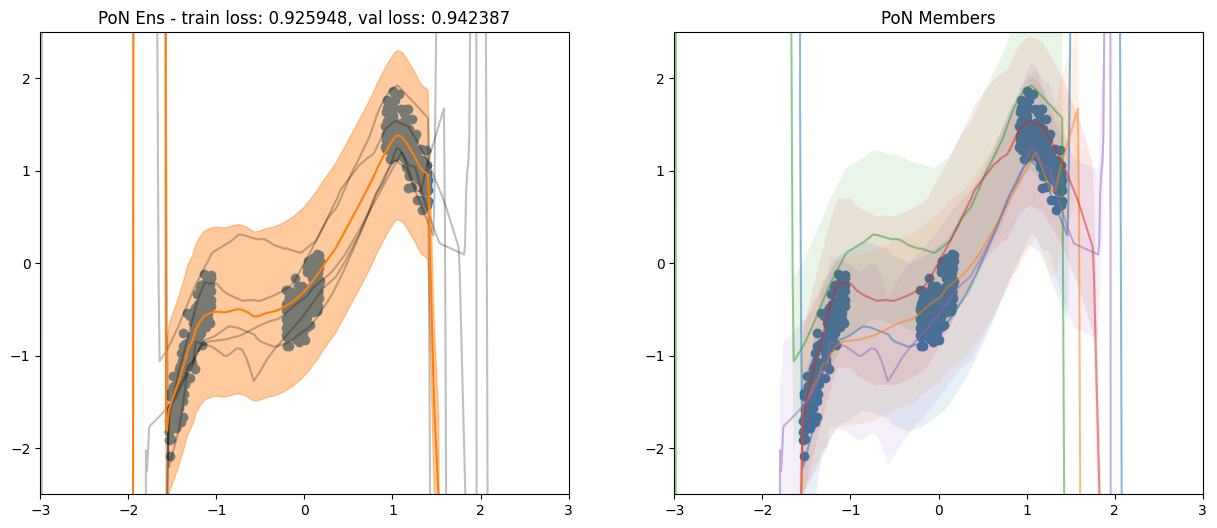

Best val_err


In [9]:
config = get_pon_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]

for i in range(1):
    for epochs in FT_EPOCHS:
        config.alpha_schedule.start = 0.
        config.alpha_schedule.end = 0.
        config.model.exact_poe = True
        config.model.noise = NOISE
        config.model.learn_weights = False
        # for alpha_schedule need to update epochs manually in config files...
        config.epochs = epochs
        rng = random.PRNGKey(i)

        setup_rng, rng = random.split(rng)

        pon_model, state = setup_training(config, setup_rng, init_x, init_y)

        if PON_RETRAIN:  # RETRAIN
            if PRETRAIN: 
                # use DE as a pretrained model
                pretrained_state = restore_checkpoint(f'dynNN_results/{PRETRAIN_MODEL}', 1)["0"]
                # pretrained_state = restore_checkpoint(f'dynNN_results/pon_model_exact_0_homo', 1)
                state = state.replace(params=frozen_dict.freeze(pretrained_state["params"]))
                state = state.replace(model_state=frozen_dict.freeze(pretrained_state["model_state"]))

            state, best_state = train_loop(
                pon_model, state, config, rng, make_PoN_Ens_loss, make_PoN_Ens_loss, train_loader, val_loader,
                # test_loader,
                wandb_kwargs={
                    'mode': 'online',
                    # 'notes': '',
                },
                plot_fn=make_PoN_Ens_plots,
            )
#             print(f"EPOCHS: {config.epochs}")
#             finetuned = f"_finetuned_{config.epochs}" if PRETRAIN else ""
#             save_checkpoint(f'dynNN_results/pon_model_exact_{i}_{NOISE}{finetuned}_pretrained_200', best_state, 1, overwrite=True)

In [ ]:
# NOISE = 'per-ens-homo'
NOISE = 'homo'
ALPHAS = [0.0, 0.5, 1.0]

In [6]:
# config = get_pon_config()

# data_gen_fn = getattr(src.data, config.dataset_name)
# train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
# train_loader = NumpyLoader(train_dataset, config.batch_size)
# val_loader = NumpyLoader(val_dataset, config.batch_size)
# test_loader = NumpyLoader(test_dataset, config.batch_size)

# init_x = train_dataset[0][0]
# init_y = train_dataset[0][1]

# for i in range(1):
#     for alpha in ALPHAS:
#         config.model.alpha = alpha
#         config.model.exact_poe = False
#         config.model.noise = NOISE
#         # config.epochs = 200
#         rng = random.PRNGKey(i)

#         setup_rng, rng = random.split(rng)

#         pon_model, state = setup_training(config, setup_rng, init_x, init_y)

#         if PON_RETRAIN:  # RETRAIN
#             state, best_state = train_loop(
#                 pon_model, state, config, rng, make_PoN_Ens_loss, make_PoN_Ens_loss, train_loader, val_loader,
#                 # test_loader,
#                 wandb_kwargs={
#                     'mode': 'offline',
#                     # 'notes': '',
#                 },
#                 plot_fn=make_PoN_Ens_plots,
#             )

#             save_checkpoint(f'dynNN_results/pon_model_{i}_approximated_{alpha}_{NOISE}_500_epochs', best_state, 1, overwrite=True)

## 2.2 PoN-GMM training

In [13]:
config = get_pogmm_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_y = train_dataset[0][1]

In [14]:
print(config)

batch_size: 500
dataset:
  heteroscedastic: false
  n_samples: 692
  noise_std: 0.25
  random_seed: 42
dataset_name: gen_simple_1d
epochs: 201
learning_rate: 0.0001
model:
  K: 2.0
  alpha: 1.0
  learn_weights: false
  learn_weights_gmm: false
  net:
    depth: 2
    hidden_size: 50
    out_size: 2
  noise: homo
  size: 5
model_name: PoN_Ens_GMM
optim:
  momentum: 0.9
  weight_decay: 0.0001
optim_name: sgdw



In [15]:
for i in range(1):
    for alpha in [0., 0.5, 1.0]:
        config.model.alpha = alpha
        
        rng = random.PRNGKey(i)

        setup_rng, rng = random.split(rng)

        pogmm_model, state = setup_training(config, setup_rng, init_x, init_y)

        if PON_GMM_RETRAIN:  # RETRAIN
            state, best_state = train_loop(
                pogmm_model, state, config, rng, make_PoN_Ens_GMM_loss, 
                make_PoN_Ens_GMM_loss, train_loader, val_loader,
                # test_loader,
                wandb_kwargs={
                    'mode': 'offline',
                    # 'notes': '',
                },
                plot_fn=make_PoN_Ens_GMM_plots,
            )

            save_checkpoint(f'dynNN_results/pogmm_model_{i}_{alpha}', best_state, 1, overwrite=True)

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

## 3. Metrics

In [12]:
X_train, y_train = list(zip(*train_loader.dataset))

In [13]:
X_test, y_test = list(zip(*test_loader.dataset))

In [83]:
def get_metrics(models):
    results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'mse', 'nll'])
    
    s = set(range(5))
    power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

    for model_name in models:
        for i in range(1):
            print(model_name)
            
            if "pog" in model_name and not 'pogmm' in model_name:
                model_type = pog_model
                state = restore_checkpoint(f'dynNN_results/{model_name}', 1)
            elif "pon" in model_name:
                model_type = pon_model
                state = restore_checkpoint(f'dynNN_results/{model_name}', 1)
            elif "pogmm" in model_name:
                model_type = pogmm_model
                state = restore_checkpoint(f'dynNN_results/{model_name}', 1)
            elif "ens" in model_name:
                model_type = ens_model
                state = restore_checkpoint(f'dynNN_results/{model_name}', 1)["0"]
                
            print(state["params"]["logscale"])

            pred_fun = partial(
                model_type.apply,
                {"params": state['params'], **state['model_state']},
                train=False, return_ens_preds=True,
                method=model_type.pred
            )
            _, (locs, scales) = jax.vmap(
                pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
            )(jnp.array(X_test))


            for indices in power_set:
                n_members = len(indices)

                if 'pog' in model_name and not 'pogmm' in model_name:
                    loc, scale = calculate_pog_loc_scale(locs[indices, :, 0], scales[indices, :, 0])
                    # loc, scale = calculate_ens_loc_scale(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                    entropies = jax.vmap(uniform_entropy)(loc, scale)
                    nlls_ = jax.vmap(uniform_nll)(loc, scale, jnp.array(y_test))
                    infs = jnp.isinf(nlls_)
                    print(f"dropping {infs.sum()} infs for prod of {n_members}")
                    nlls = nlls_[~infs]
                elif 'pon' in model_name:
                    loc, scale = normal_prod(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                    # loc, scale = calculate_ens_loc_scale(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                    entropies = jax.vmap(normal_entropy)(loc, scale)
                    nlls_ = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
                    infs = jnp.isinf(nlls_)
                    assert infs.sum() == 0
                    # print(f"dropping {infs.sum()} infs for pon of {n_members}")
                    nlls = nlls_[~infs]
                elif 'ens' in model_name:
                    loc, scale = calculate_ens_loc_scale(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                    entropies = jax.vmap(normal_entropy)(loc, scale)
                    nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
                elif 'pogmm' in model_name:
                    _locs, _scales = jnp.transpose(locs[indices, :, :], axes=[1, 0, 2]), jnp.transpose(scales[indices, :, :], axes=[1, 0, 2])
                    loc, scale = jax.vmap(monte_carlo_pred, in_axes=(0, 0, None))(_locs, _scales, 1/n_members)
                    entropies = jax.vmap(normal_entropy)(loc, scale)
                    nlls_ = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
                    infs = jnp.isinf(nlls_)
                    print(f"dropping {infs.sum()} infs for pon of {n_members}")
                    nlls = nlls_[~infs]
                else:
                    raise ValueError()

                errors = jax.vmap(mse)(loc, jnp.array(y_test))

                results_df = pd.concat([
                    results_df,
                    pd.DataFrame({
                        'model_name': [model_name],
                        'n_members': [n_members],
                        'random_seed': [i],
                        'H': [entropies.mean()],
                        'nll': [nlls.mean()],
                        'mse': [errors.mean()],
                    })],
                    ignore_index=True
                )
                
    min_mse_df = results_df[results_df.n_members == 5][['model_name', 'random_seed', 'mse', 'nll']].rename(
    columns={'mse': 'final_mse', 'nll': 'final_nll'}
)
    tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
    tmp_df['mse_diff'] = tmp_df['mse'] - tmp_df['final_mse'] 
    tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
    
    agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'mse_diff': ['mean', 'std', 'count'],
    'mse': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
})
    agg_df[('H', 'std_err')] = agg_df[('H', 'std')] / agg_df[('H', 'count')]
    agg_df[('mse_diff', 'std_err')] = agg_df[('mse_diff', 'std')] / agg_df[('mse_diff', 'count')]
    agg_df[('mse', 'std_err')] = agg_df[('mse', 'std')] / agg_df[('mse', 'count')]
    agg_df[('nll_diff', 'std_err')] = agg_df[('nll_diff', 'std')] / agg_df[('nll_diff', 'count')]
    agg_df[('nll', 'std_err')] = agg_df[('nll', 'std')] / agg_df[('nll', 'count')]
    
    return agg_df

In [84]:
def generate_name(model_type, i, members_ll, alpha, beta, ft=None):
    members_ll = members_ll if members_ll else ""
    alpha = alpha if alpha is not None else ""
    beta = beta if beta is not None else ""
    pretrained = f"__pretrained_{ft}" if ft is not None else ""
    return f"{model_type}_model_{i}_{members_ll}_{alpha}_{beta}".rstrip("_") + pretrained

## 4) experiments

##  main findings:
- plot 0: closer look at the role of pretraining
- plot 1: having $w_M$ in PoE hurts performance, since we are multiplying gradients with e.g. 0.2, so it takes longer for model to converge
- plot 2: 
    - aligning distributions between product and DE terms in objective function does not fully close the performance gap (contrary to the classification case)
    - magnitudes of Z and DE term seem to be well aligned (see runs 206-208 on wandb), i.e. their ratio is mainly around 1 and seems to be quite independent of alpha. isn't that a bit strange, though? one would expect that by varying alpha the terms would be decreasing at different speeds? ratio between Z and DE is also very well behaved for classification example (see runs 210-212 on wandb)... strange, or?
- plot 3: 
    - as we increasing the "importance" of the product term in the objective function, the performance of individual base learners gets worse. 
    - for alpha=1 PoE is equivalent to DE with GNDs. it is encouracing to see that the performance is similar to a DE of Gaussians, meaning we are not losing too much performance due to working with GNDs
- plot 4:
    - when Z is part of the objective functions, individual base learners learn biased representations that then cancel out in product distribution, see histrograms at the end of this notebook
- plot 5: effect of pretraining
    - alpha=0.
        - TOOD
    - alpha=0.5
        - TODO
    - alpha=1.0
        - TODO

### plot 0

In [95]:
models = ["pon_model_exact_0_homo", "ens_model_0", "ens_model_0_100_epochs"] +  \
    [f"pon_model_exact_0_homo_finetuned_{epochs}_pretrained_{pt_epochs}" for epochs in [0, 10, 50, 100, 200] for pt_epochs in [100, 200]]

In [99]:
models

['pon_model_exact_0_homo',
 'ens_model_0',
 'ens_model_0_100_epochs',
 'pon_model_exact_0_homo_finetuned_0_pretrained_100',
 'pon_model_exact_0_homo_finetuned_0_pretrained_200',
 'pon_model_exact_0_homo_finetuned_10_pretrained_100',
 'pon_model_exact_0_homo_finetuned_10_pretrained_200',
 'pon_model_exact_0_homo_finetuned_50_pretrained_100',
 'pon_model_exact_0_homo_finetuned_50_pretrained_200',
 'pon_model_exact_0_homo_finetuned_100_pretrained_100',
 'pon_model_exact_0_homo_finetuned_100_pretrained_200',
 'pon_model_exact_0_homo_finetuned_200_pretrained_100',
 'pon_model_exact_0_homo_finetuned_200_pretrained_200']

In [100]:
metrics_df = get_metrics(models)

pon_model_exact_0_homo
[-0.16623455]
ens_model_0
[-0.7085461]
ens_model_0_100_epochs
[-0.28912452]
pon_model_exact_0_homo_finetuned_0_pretrained_100
[-0.28912452]
pon_model_exact_0_homo_finetuned_0_pretrained_200
[-0.7085461]
pon_model_exact_0_homo_finetuned_10_pretrained_100
[-0.2930113]
pon_model_exact_0_homo_finetuned_10_pretrained_200
[-0.70863324]
pon_model_exact_0_homo_finetuned_50_pretrained_100
[-0.32766005]
pon_model_exact_0_homo_finetuned_50_pretrained_200
[-0.70863324]
pon_model_exact_0_homo_finetuned_100_pretrained_100
[-0.3622664]
pon_model_exact_0_homo_finetuned_100_pretrained_200
[-0.70863324]
pon_model_exact_0_homo_finetuned_200_pretrained_100
[-0.4672049]
pon_model_exact_0_homo_finetuned_200_pretrained_200
[-0.70863324]


In [101]:
metrics_df

H  \
                                                                  mean   
model_name                                         n_members             
ens_model_0                                        1          0.710392   
                                                   2          0.711452   
                                                   3          0.711807   
                                                   4          0.711984   
                                                   5          0.712091   
...                                                                ...   
pon_model_exact_0_homo_finetuned_50_pretrained_200 1          0.710305   
                                                   2          0.710305   
                                                   3          0.710305   
                                                   4          0.710305   
                                                   5          0.710305   

                                                                              \
                                                                   std count   
model_name                                         n_members                   
ens_model_0                                        1          0.000000     5   
                                                   2          0.000467    10   
                                                   3          0.000405    10   
                                                   4          0.000294     5   
                                                   5               NaN     1   
...                                                                ...   ...   
pon_model_exact_0_homo_finetuned_50_pretrained_200 1          0.000000     5   
                                                   2          0.000000    10   
                                                   3          0.000000    10   
                                                   4          0.000000     5   
                                                   5               NaN     1   

                                                              mse_diff  \
                                                                  mean   
model_name                                         n_members             
ens_model_0                                        1          0.000827   
                                                   2          0.000310   
                                                   3          0.000138   
                                                   4          0.000052   
                                                   5          0.000000   
...                                                                ...   
pon_model_exact_0_homo_finetuned_50_pretrained_200 1          0.000794   
                                                   2          0.000298   
                                                   3          0.000132   
                                                   4          0.000050   
                                                   5          0.000000   

                                                                              \
                                                                   std count   
model_name                                         n_members                   
ens_model_0                                        1          0.000708     5   
                                                   2          0.000293    10   
                                                   3          0.000186    10   
                                                   4          0.000120     5   
                                                   5               NaN     1   
...                                                                ...   ...   
pon_model_exact_0_homo_finetuned_50_pretrained_200 1          0.000677     5   
                                                   2          0.000261    

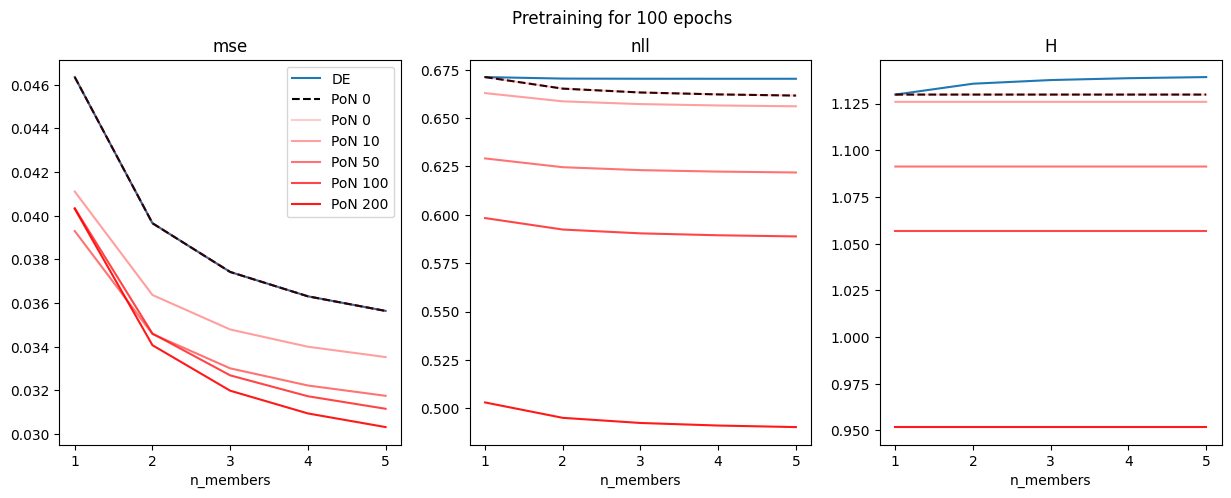

In [115]:
PRETRAINING = 100
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
# metrics_df[METRIC]["mean"].loc['ens_model_0_100_epochs', :].plot(ax=axes[0], label="DE")
# # metrics_df[METRIC]["mean"].loc['ens_model_0_100_epochs', :].plot(ax=axes[1], label="DE")
# metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(ax=axes[0], label="DE")
# metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(ax=axes[1], label="DE")
# metrics_df[METRIC]["mean"].loc['pon_model_exact_0_homo', :].plot(ax=axes[1], label="PoN (no pretraining)")


FT_EPOCHS = [0, 10, 50, 100, 200]
for j, metric in enumerate(["mse", "nll", "H"]):
    ft_plot = np.linspace(0.2, 0.9, len(FT_EPOCHS))
    if PRETRAINING == 100:
        ending = "_100_epochs"
    elif PRETRAINING == 200:
        ending = ""
    else:
        raise ValueError()
    metrics_df[metric]["mean"].loc[f'ens_model_0{ending}', :].plot(ax=axes[j], label="DE")
    metrics_df[metric]["mean"].loc[f'pon_model_exact_0_homo_finetuned_0_pretrained_{PRETRAINING}', :].plot(ax=axes[j], label="PoN 0", 
                                                                     color="black", linestyle="--")
    for i, ft in enumerate(FT_EPOCHS):
        
        model_name = f'pon_model_exact_0_homo_finetuned_{ft}_pretrained_{PRETRAINING}'
        metrics_df[metric]["mean"].loc[model_name, :].plot(ax=axes[j], 
                                                           label=f"PoN {ft}",
                                                            color="red", 
                                                            alpha=ft_plot[i])
    axes[j].set_title(metric)
    
    

fig.suptitle(f"Pretraining for {PRETRAINING} epochs")
axes[0].legend()
# axes[1].legend()
# axes[2].legend()
plt.show()

### plot 1

In [72]:
models = ["pog_model_0_GND_1.0_16_tempered", "pog_model_0_GND_1.0_16_tempered_1000_epochs", "pog_model_0_GND_1.0_16", "pog_model_0_gaussian_1.0_16", "ens_model_0", "ens_model_0_400_epochs"]

In [73]:
metrics_df = get_metrics(models)

pog_model_0_GND_1.0_16_tempered
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 0 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 0 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 4
dropping 1 infs for prod of 4
dropping 0 infs for prod of 4
dropping 1 infs for prod of 4
dropping 1 infs for prod of 4
dropping 1 infs for prod of 5
pog_model_0_GND_1.0_16_tempered_1000_e

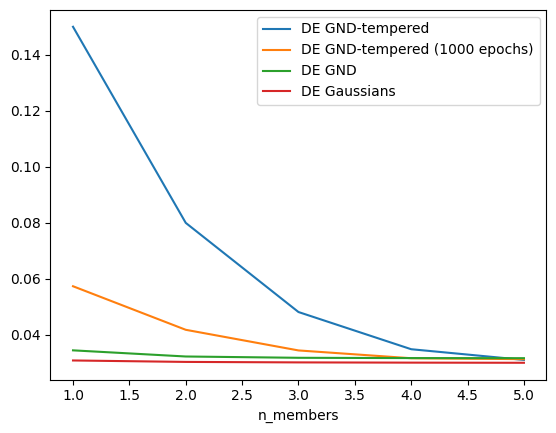

In [76]:
METRIC = "mse"
model_name = f'pog_model_0_GND_1.0_16_tempered'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label="DE GND-tempered", 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_GND_1.0_16_tempered_1000_epochs'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label="DE GND-tempered (1000 epochs)", 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_GND_1.0_16'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label="DE GND"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE Gaussians"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

### plot 2

In [25]:
BETA_END = [2, 8 ,16]
ALPHAS = [0., 0.5, 1.]

In [26]:
models = [generate_name("ens", 0, None, None, None)] + [generate_name("pog", 0, members_ll, alpha, beta) for alpha in ALPHAS for beta in BETA_END for members_ll in [MEMBERS_LL.GND.value, MEMBERS_LL.gaussian.value]]
models

['ens_model_0',
 'pog_model_0_GND_0.0_2',
 'pog_model_0_gaussian_0.0_2',
 'pog_model_0_GND_0.0_8',
 'pog_model_0_gaussian_0.0_8',
 'pog_model_0_GND_0.0_16',
 'pog_model_0_gaussian_0.0_16',
 'pog_model_0_GND_0.5_2',
 'pog_model_0_gaussian_0.5_2',
 'pog_model_0_GND_0.5_8',
 'pog_model_0_gaussian_0.5_8',
 'pog_model_0_GND_0.5_16',
 'pog_model_0_gaussian_0.5_16',
 'pog_model_0_GND_1.0_2',
 'pog_model_0_gaussian_1.0_2',
 'pog_model_0_GND_1.0_8',
 'pog_model_0_gaussian_1.0_8',
 'pog_model_0_GND_1.0_16',
 'pog_model_0_gaussian_1.0_16']

In [27]:
metrics_df = get_metrics(models)

ens_model_0
pog_model_0_GND_0.0_2
dropping 79 infs for prod of 1
dropping 45 infs for prod of 1
dropping 64 infs for prod of 1
dropping 105 infs for prod of 1
dropping 26 infs for prod of 1
dropping 103 infs for prod of 2
dropping 23 infs for prod of 2
dropping 68 infs for prod of 2
dropping 71 infs for prod of 2
dropping 47 infs for prod of 2
dropping 35 infs for prod of 2
dropping 71 infs for prod of 2
dropping 72 infs for prod of 2
dropping 13 infs for prod of 2
dropping 54 infs for prod of 2
dropping 58 infs for prod of 3
dropping 29 infs for prod of 3
dropping 104 infs for prod of 3
dropping 9 infs for prod of 3
dropping 23 infs for prod of 3
dropping 50 infs for prod of 3
dropping 32 infs for prod of 3
dropping 48 infs for prod of 3
dropping 32 infs for prod of 3
dropping 14 infs for prod of 3
dropping 0 infs for prod of 4
dropping 58 infs for prod of 4
dropping 30 infs for prod of 4
dropping 3 infs for prod of 4
dropping 9 infs for prod of 4
dropping 0 infs for prod of 5
pog_mod

dropping 1 infs for prod of 3
dropping 3 infs for prod of 3
dropping 3 infs for prod of 3
dropping 3 infs for prod of 3
dropping 6 infs for prod of 4
dropping 6 infs for prod of 4
dropping 6 infs for prod of 4
dropping 6 infs for prod of 4
dropping 3 infs for prod of 4
dropping 6 infs for prod of 5
pog_model_0_gaussian_0.5_8
dropping 3 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 3 infs for prod of 2
dropping 4 infs for prod of 2
dropping 3 infs for prod of 2
dropping 4 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 2 infs for prod of 2
dropping 1 infs for prod of 2
dropping 4 infs for prod of 3
dropping 3 infs for prod of 3
dropping 4 infs for prod of 3
dropping 4 infs for prod of 3
dropping 5 infs for prod of 3
dropping 4 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 in

dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 2 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 0 infs for prod of 3
dropping 2 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 4
dropping 1 infs for prod of 4
dropping 1 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 5


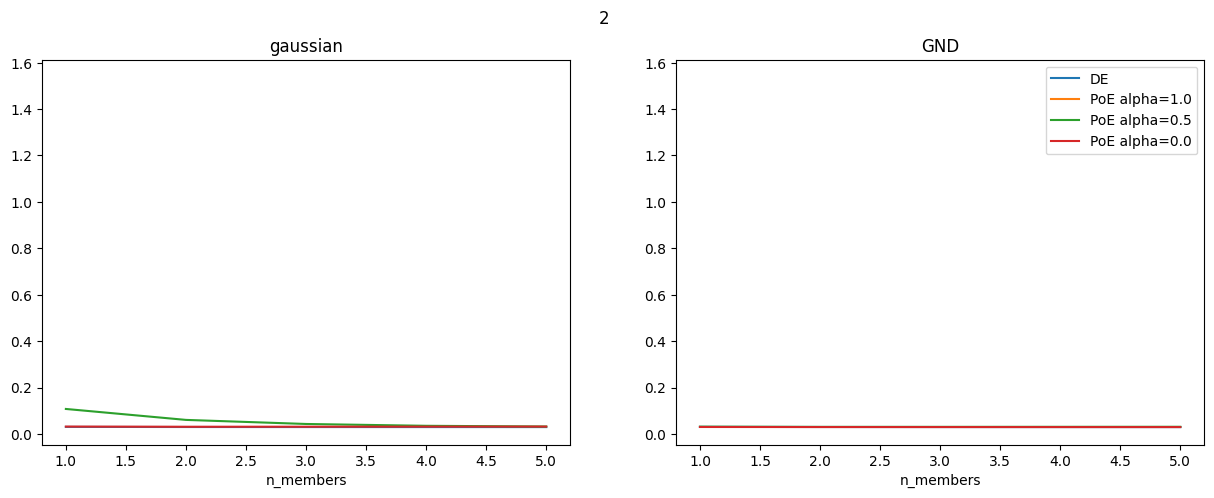

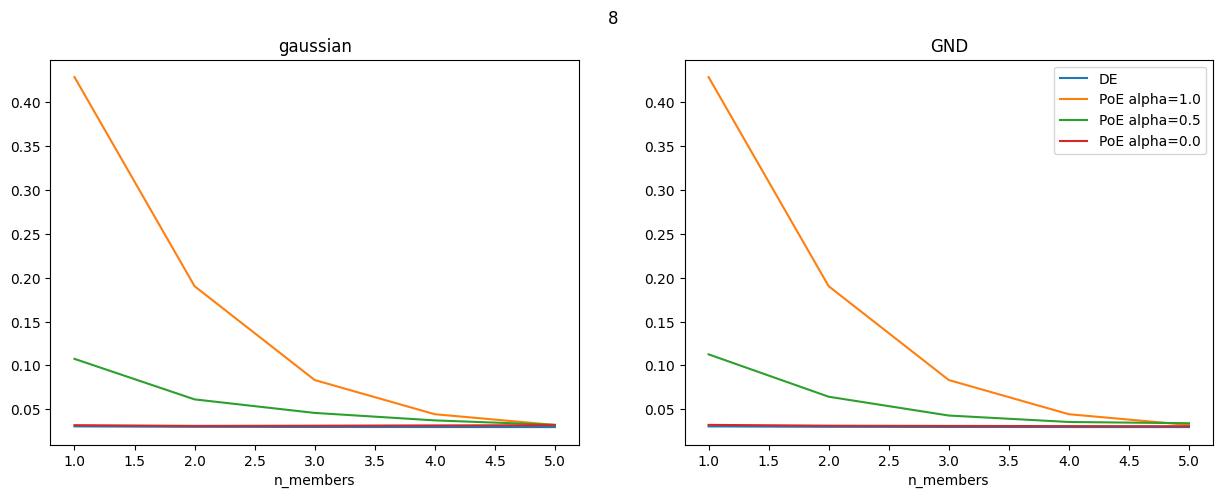

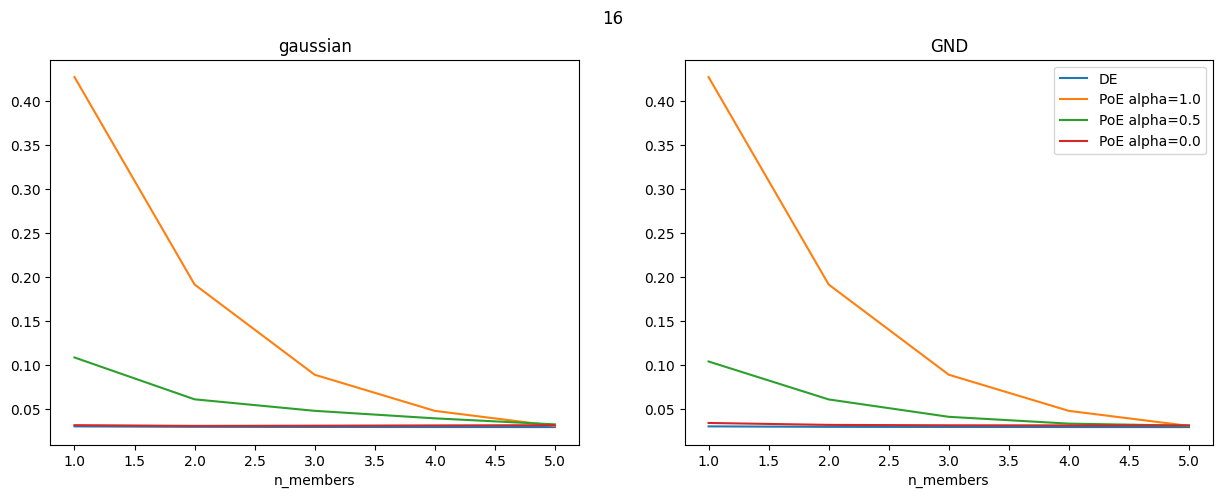

In [28]:
METRIC = "mse"
for beta in BETA_END:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(ax=axes[0], label="DE")
    metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(ax=axes[1], label="DE")

    # alpha_plot = np.linspace(0.2, 0.9, len(ALPHAS))
    for i, alpha in enumerate(ALPHAS):
         #if alpha == 0.5:
        model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{alpha}_{beta}'
        metrics_df[METRIC]["mean"].loc[model_name, :].plot(
                                                           ax=axes[0], 
                                                           label=f"PoE alpha={1 - alpha}", 
                                                           # color="red", 
                                                           # alpha=alpha_plot[i]
                                                            )
        model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{alpha}_{beta}'
        metrics_df[METRIC]["mean"].loc[model_name, :].plot(
                                                           ax=axes[1], 
                                                           label=f"PoE alpha={1 - alpha}", 
                                                           # color="red", 
                                                           # alpha=alpha_plot[i]
                                                            )

    axes[1].set_title(MEMBERS_LL.GND.value)
    axes[0].set_title(MEMBERS_LL.gaussian.value)
    
    fig.suptitle(beta)
    plt.legend()
    plt.show()

### plot 3

In [13]:
BETA_END = [16]
ALPHAS = [0., 0.5, 1.]

In [14]:
models = [generate_name("ens", 0, None, None, None)] + [generate_name("pog", 0, members_ll, alpha, beta) for alpha in ALPHAS for beta in BETA_END for members_ll in [MEMBERS_LL.GND.value]]
models

['ens_model_0',
 'pog_model_0_GND_0.0_16',
 'pog_model_0_GND_0.5_16',
 'pog_model_0_GND_1.0_16']

In [15]:
metrics_df = get_metrics(models)

ens_model_0
pog_model_0_GND_0.0_16
dropping 3 infs for prod of 1
dropping 2 infs for prod of 1
dropping 0 infs for prod of 1
dropping 2 infs for prod of 1
dropping 1 infs for prod of 1
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 2 infs for prod of 2
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 4
dropping 0 infs for prod of 4
dropping 0 infs for prod of 4
dropping 0 infs for prod of 4
dropping 0 infs for prod of 4
dropping 0 infs for prod of 5
pog_model_0_GND_0.5_16
dropping 3 i

In [17]:
metrics_df

H                      mse_diff  \
                                      mean           std count      mean   
model_name             n_members                                           
ens_model_0            1          0.710392  0.000000e+00     5  0.000827   
                       2          0.711452  4.668710e-04    10  0.000310   
                       3          0.711807  4.054957e-04    10  0.000138   
                       4          0.711984  2.941170e-04     5  0.000052   
                       5          0.712091           NaN     1  0.000000   
pog_model_0_GND_0.0_16 1          0.816749  2.665601e-08     5  0.396284   
                       2          0.292679  2.975092e-01    10  0.160631   
                       3         -0.033387  2.323056e-01    10  0.058162   
                       4         -0.238261  1.397163e-01     5  0.017101   
                       5         -0.372855           NaN     1  0.000000   
pog_model_0_GND_0.5_16 1          0.351694  1.632340e-08     5  0.072943   
                       2          0.048645  1.516464e-01    10  0.029840   
                       3         -0.120765  9.803678e-02    10  0.010088   
                       4         -0.213871  4.010580e-02     5  0.002352   
                       5         -0.266207           NaN     1  0.000000   
pog_model_0_GND_1.0_16 1          0.041879  2.040426e-09     5  0.002796   
                       2         -0.031848  2.038917e-02    10  0.000600   
                       3         -0.070310  1.662181e-02    10  0.000134   
                       4         -0.095381  1.113320e-02     5  0.000035   
                       5         -0.113526           NaN     1  0.000000   

                                                       mse                  \
                                       std count      mean       std count   
model_name             n_members                                             
ens_model_0            1          0.000708     5  0.030861  0.000708     5   
                       2          0.000293    10  0.030344  0.000293    10   
                       3          0.000186    10  0.030172  0.000186    10   
                       4          0.000120     5  0.030086  0.000120     5   
                       5               NaN     1  0.030034       NaN     1   
pog_model_0_GND_0.0_16 1          0.123256     5  0.427408  0.123256     5   
                       2          0.145143    10  0.191756  0.145143    10   
                       3          0.080951    10  0.089287  0.080951    10   
                       4          0.031736     5  0.048226  0.031736     5   
                       5               NaN     1  0.031125       NaN     1   
pog_model_0_GND_0.5_16 1          0.024159     5  0.104314  0.024159     5   
                       2          0.026783    10  0.061211  0.026783    10   
                       3          0.013248    10  0.041458  0.013248    10   
                       4          0.002013     5  0.033723  0.002013     5   
                       5               NaN     1  0.031370       NaN     1   
pog_model_0_GND_1.0_16 1          0.002991     5  0.034476  0.002991     5   
                       2          0.001445    10  0.032280  0.001445    10   
                       3          0.000769    10  0.031814  0.000769    10   
                       4          0.000558     5  0.031715  0.000558     5   
                       5               NaN     1  0.031680       NaN     1   

                                  nll_diff                           nll  \
                                      mean           std count      mean   
model_name             n_members                                           
ens_model_0            1          0.000215  1.459695e-03     5  0.274045   
                       2          0.000073  7.804625e-04    10  0.273902   
                       3          0.000032  5.104739e-04    10  0.273861   
                       4          0.00001

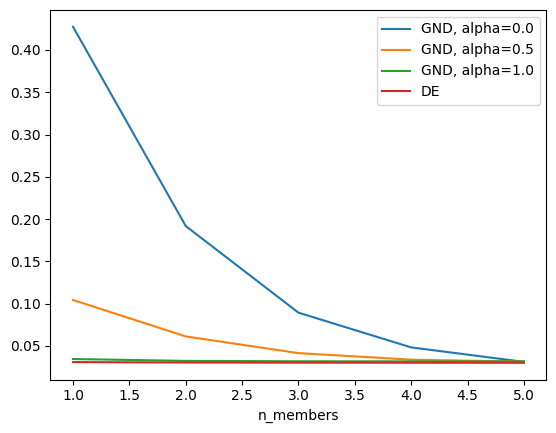

In [18]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.0}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=f"{MEMBERS_LL.GND.value}, alpha={0.0}", 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.5}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=f"{MEMBERS_LL.GND.value}, alpha={0.5}",
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{1.0}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=f"{MEMBERS_LL.GND.value}, alpha={1.0}",
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

## plot 4

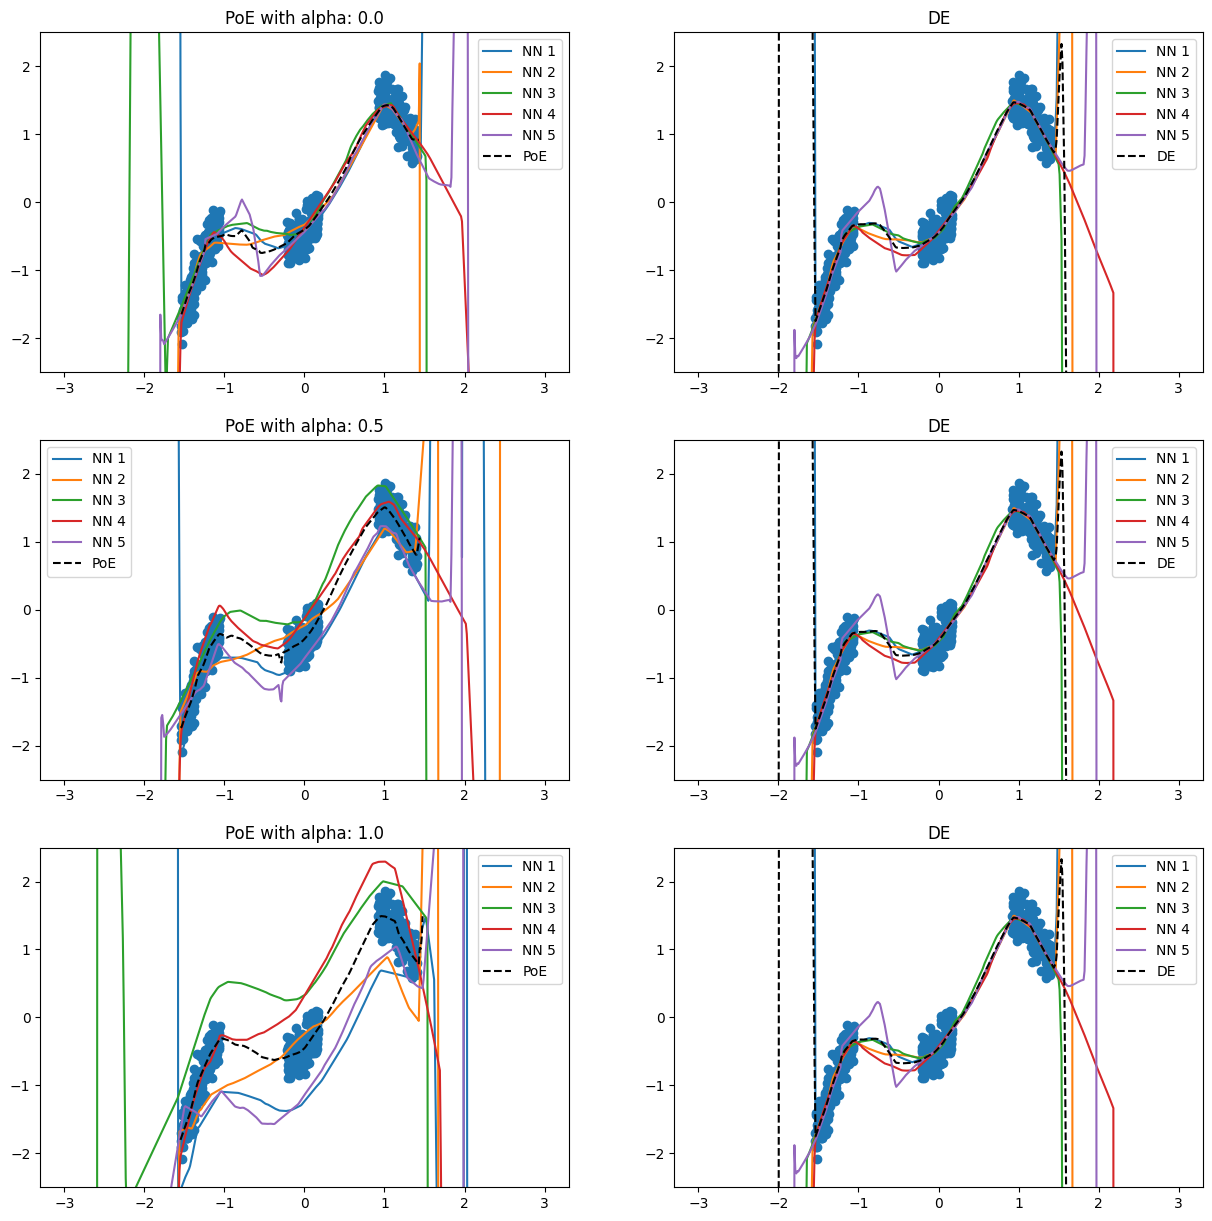

In [33]:
xs = jnp.linspace(-3, 3, num=501)

model_type = ens_model
state = restore_checkpoint(f'dynNN_results/ens_model_0', 1)["0"]

pred_fun = partial(
    model_type.apply,
    {"params": state['params'], **state['model_state']},
    train=False, return_ens_preds=True,
    method=model_type.pred
)
(loc, scale), (locs, scales) = jax.vmap(
    pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
)(jnp.array(xs.reshape(-1, 1)))

fig, axs = plt.subplots(3 ,2, figsize=(15, 15))
for j, alpha in enumerate(ALPHAS[::-1]):
    
    axs[j, 0].scatter(X_train, y_train)
    axs[j, 1].scatter(X_train, y_train)
    model_type = pog_model
    state = restore_checkpoint(f'dynNN_results/pog_model_0_GND_{alpha}_16', 1)

    pred_fun_gnd = partial(
        model_type.apply,
        {"params": state['params'], **state['model_state']},
        train=False, return_ens_preds=True,
        method=model_type.pred
    )
    (loc_gnd, scale_gnd), (locs_gnd, scales_gnd) = jax.vmap(
        pred_fun_gnd, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
    )(xs.reshape(-1, 1))
    
    
    for i in range(5):
        axs[j, 0].plot(xs, locs_gnd[i], label=f"NN {i + 1}")
        
    for i in range(5):
        axs[j, 1].plot(xs, locs[i], label=f"NN {i + 1}")
        
    axs[j, 0].plot(xs, loc_gnd, label="PoE", linestyle="--", color="black")
    axs[j, 1].plot(xs, loc, label="DE", linestyle="--", color="black")
        
    axs[j, 0].set_ylim(-2.5, 2.5)
    axs[j, 1].set_ylim(-2.5, 2.5)
    
    
    
    
    axs[j, 0].set_title(f"PoE with alpha: {1 - alpha}")
    axs[j, 1].set_title(f"DE")
    axs[j, 0].legend()
    axs[j, 1].legend()
plt.savefig("regression_base_learners.pdf")
plt.show()

### plot 5

In [29]:
MEMBERS_LL = MembersLL.GND
# MEMBERS_LL = MembersLL.gaussian
# BETA_END = [2, 8 ,16]
ALPHAS = [0., 0.5, 1.]
BETA_END = [16]
# ALPHAS = [0.5]
BETA_START = [2, 16]
FT_EPOCHS = [0, 10, 25, 50, 100]
PRETRAIN = True

In [30]:
models = [generate_name("ens", 0, None, None, None, None)] + [generate_name("pog", 0, members_ll, alpha, beta, ft) for alpha in ALPHAS for beta in BETA_START for members_ll in [MEMBERS_LL.GND.value] for ft in FT_EPOCHS]
models += ["pog_model_0_pretrained_GND"]
models

['ens_model_0',
 'pog_model_0_GND_0.0_2__pretrained_0',
 'pog_model_0_GND_0.0_2__pretrained_10',
 'pog_model_0_GND_0.0_2__pretrained_25',
 'pog_model_0_GND_0.0_2__pretrained_50',
 'pog_model_0_GND_0.0_2__pretrained_100',
 'pog_model_0_GND_0.0_16__pretrained_0',
 'pog_model_0_GND_0.0_16__pretrained_10',
 'pog_model_0_GND_0.0_16__pretrained_25',
 'pog_model_0_GND_0.0_16__pretrained_50',
 'pog_model_0_GND_0.0_16__pretrained_100',
 'pog_model_0_GND_0.5_2__pretrained_0',
 'pog_model_0_GND_0.5_2__pretrained_10',
 'pog_model_0_GND_0.5_2__pretrained_25',
 'pog_model_0_GND_0.5_2__pretrained_50',
 'pog_model_0_GND_0.5_2__pretrained_100',
 'pog_model_0_GND_0.5_16__pretrained_0',
 'pog_model_0_GND_0.5_16__pretrained_10',
 'pog_model_0_GND_0.5_16__pretrained_25',
 'pog_model_0_GND_0.5_16__pretrained_50',
 'pog_model_0_GND_0.5_16__pretrained_100',
 'pog_model_0_GND_1.0_2__pretrained_0',
 'pog_model_0_GND_1.0_2__pretrained_10',
 'pog_model_0_GND_1.0_2__pretrained_25',
 'pog_model_0_GND_1.0_2__pretrai

In [31]:
metrics_df = get_metrics(models)

ens_model_0
pog_model_0_GND_0.0_2__pretrained_0
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 1 infs for prod of 1
dropping 2 infs for prod of 1
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 2 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 2 infs for prod of 2
dropping 2 infs for prod of 2
dropping 3 infs for prod of 2
dropping 3 infs for prod of 2
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 3
dropping 3 infs for prod of 3
dropping 3 infs for prod of 3
dropping 2 infs for prod of 3
dropping 3 infs for prod of 3
dropping 3 infs for prod of 3
dropping 4 infs for prod of 3
dropping 2 infs for prod of 4
dropping 3 infs for prod of 4
dropping 3 infs for prod of 4
dropping 4 infs for prod of 4
dropping 4 infs for prod of 4
dropping 4 infs for prod of 5
pog_model_0_GND_0.0_2_

dropping 11 infs for prod of 3
dropping 2 infs for prod of 3
dropping 8 infs for prod of 3
dropping 10 infs for prod of 3
dropping 10 infs for prod of 3
dropping 3 infs for prod of 4
dropping 11 infs for prod of 4
dropping 11 infs for prod of 4
dropping 11 infs for prod of 4
dropping 10 infs for prod of 4
dropping 11 infs for prod of 5
pog_model_0_GND_0.0_16__pretrained_100
dropping 3 infs for prod of 1
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 2 infs for prod of 1
dropping 8 infs for prod of 1
dropping 3 infs for prod of 2
dropping 3 infs for prod of 2
dropping 3 infs for prod of 2
dropping 11 infs for prod of 2
dropping 0 infs for prod of 2
dropping 2 infs for prod of 2
dropping 8 infs for prod of 2
dropping 2 infs for prod of 2
dropping 8 infs for prod of 2
dropping 10 infs for prod of 2
dropping 3 infs for prod of 3
dropping 3 infs for prod of 3
dropping 11 infs for prod of 3
dropping 3 infs for prod of 3
dropping 11 infs for prod of 3
dropping 11 infs fo

dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 2 infs for prod of 2
dropping 0 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 3
dropping 1 infs for prod of 4
dropping 1 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 5
pog_model_0_GND_0.5_16__pretrained_50
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 1 infs for prod of 1
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dr

dropping 4 infs for prod of 5
pog_model_0_GND_1.0_16__pretrained_10
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 1 infs for prod of 1
dropping 1 infs for prod of 1
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 2 infs for prod of 2
dropping 2 infs for prod of 2
dropping 2 infs for prod of 2
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 3
dropping 3 infs for prod of 3
dropping 2 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 4
dropping 3 infs for prod of 4
dropping 3 infs for prod of 4
dropping 3 infs for prod of 5
po

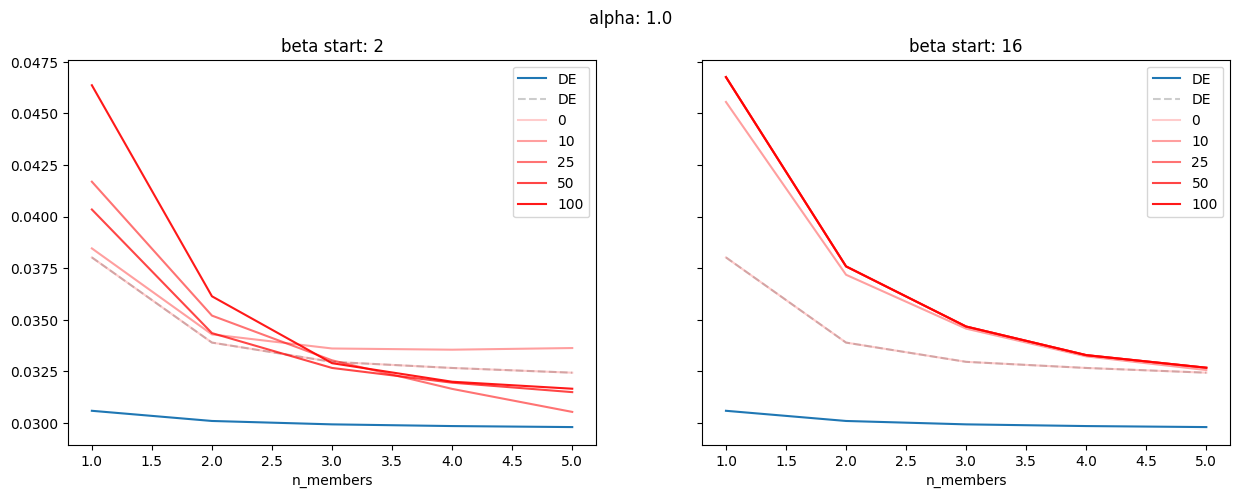

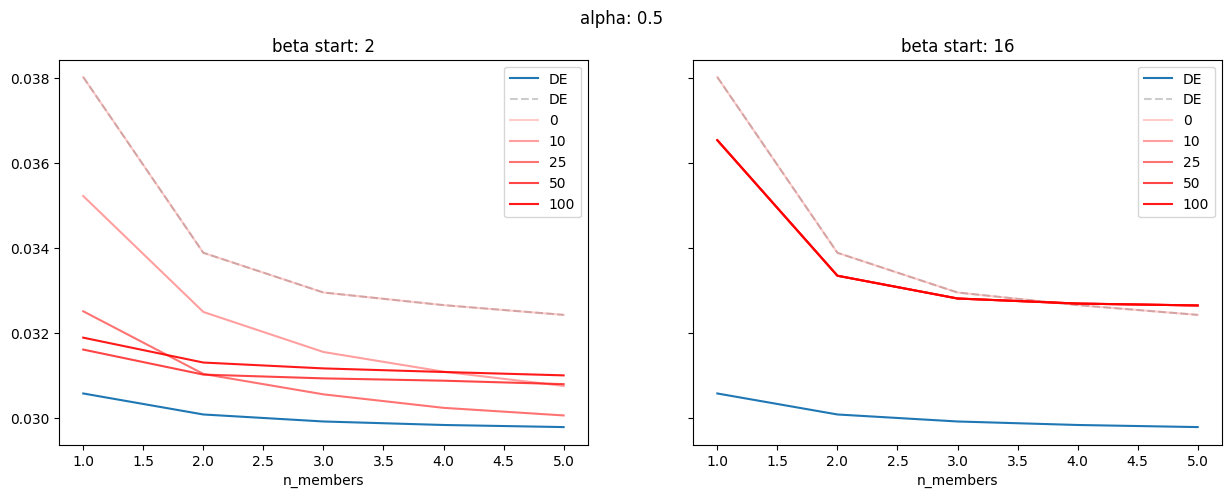

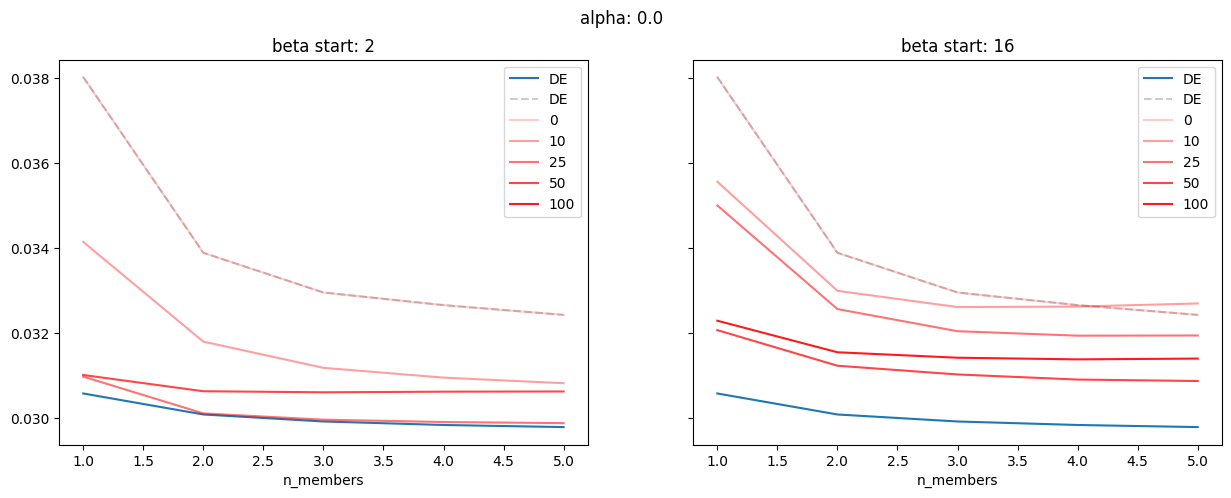

In [32]:
METRIC = "mse"
for alpha in ALPHAS:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
    metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(ax=axes[0], label="DE")
    metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(ax=axes[1], label="DE")
    
    metrics_df[METRIC]["mean"].loc['pog_model_0_pretrained_GND', :].plot(ax=axes[0], label="DE", 
                                                                         color="black", linestyle="--", alpha=0.2)
    metrics_df[METRIC]["mean"].loc['pog_model_0_pretrained_GND', :].plot(ax=axes[1], label="DE", 
                                                                         color="black", linestyle="--", alpha=0.2)
    for j, beta in enumerate(BETA_START):
        ft_plot = np.linspace(0.2, 0.9, len(FT_EPOCHS))
        for i, ft in enumerate(FT_EPOCHS):
            model_name = f'pog_model_0_{MembersLL.GND.value}_{alpha}_{beta}__pretrained_{ft}'
            metrics_df[METRIC]["mean"].loc[model_name, :].plot(
                                                                       ax=axes[j], 
                                                                       label=ft, 
                                                                       color="red", 
                                                                       alpha=ft_plot[i])
        axes[j].set_title(f"beta start: {beta}")
    fig.suptitle(f"alpha: {1 - alpha}")
    axes[0].legend()
    axes[1].legend()
    plt.show()


- try pretraining base learners and only bring in product term in the finetuning phase

In [104]:
jnp.arange(-10, 10, 0.001).shape

(20000,)

### plot 6: PoN vs approximated PoN

#### plot 6.1 homoscedastic noise

see runs 231-233 on wandb

In [17]:
models = ["pon_model_0_approximated_0.0", 
          "pon_model_0_approximated_0.5", 
          "pon_model_0_approximated_1.0", 
          "pon_model_0"]

In [18]:
metrics_df = get_metrics(models)

pon_model_0_approximated_0.0
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 5
pon_model_0_approximated_0.5
dropping 0 infs for pon of 1
dropping 0 inf

In [19]:
metrics_df

H             mse_diff  \
                                            mean  std count      mean   
model_name                   n_members                                  
pon_model_0                  1          1.252704  0.0     5  1.277654   
                             2          1.252704  0.0    10  0.479120   
                             3          1.252704  0.0    10  0.212942   
                             4          1.252704  0.0     5  0.079853   
                             5          1.252704  NaN     1  0.000000   
pon_model_0_approximated_0.0 1          0.710392  0.0     5  0.000827   
                             2          0.710392  0.0    10  0.000310   
                             3          0.710392  0.0    10  0.000138   
                             4          0.710392  0.0     5  0.000052   
                             5          0.710392  NaN     1  0.000000   
pon_model_0_approximated_0.5 1          1.018297  0.0     5  0.003834   
                             2          1.018297  0.0    10  0.001438   
                             3          1.018297  0.0    10  0.000639   
                             4          1.018297  0.0     5  0.000240   
                             5          1.018297  NaN     1  0.000000   
pon_model_0_approximated_1.0 1          1.290388  0.0     5  1.262706   
                             2          1.290388  0.0    10  0.473515   
                             3          1.290388  0.0    10  0.210451   
                             4          1.290388  0.0     5  0.078919   
                             5          1.290388  NaN     1  0.000000   

                                                             mse            \
                                             std count      mean       std   
model_name                   n_members                                       
pon_model_0                  1          0.917640     5  1.309491  0.917640   
                             2          0.264111    10  0.510957  0.264111   
                             3          0.110241    10  0.244779  0.110241   
                             4          0.046174     5  0.111690  0.046174   
                             5               NaN     1  0.031836       NaN   
pon_model_0_approximated_0.0 1          0.000708     5  0.030861  0.000708   
                             2          0.000293    10  0.030344  0.000293   
                             3          0.000186    10  0.030172  0.000186   
                             4          0.000120     5  0.030086  0.000120   
                             5               NaN     1  0.030034       NaN   
pon_model_0_approximated_0.5 1          0.002861     5  0.034455  0.002861   
                             2          0.001405    10  0.032059  0.001405   
                             3          0.000950    10  0.031260  0.000950   
                             4          0.000630     5  0.030861  0.000630   
                             5               NaN     1  0.030621       NaN   
pon_model_0_approximated_1.0 1          0.828186     5  1.292913  0.828186   
                             2          0.241512    10  0.503722  0.241512   
                             3          0.114685    10  0.240659  0.114685   
                             4          0.061971     5  0.109127  0.061971   
                             5               NaN     1  0.030208       NaN   

                                              nll_diff                  \
                                       count      mean       std count   
model_name                   n_members                                   
pon_model_0                  1             5  0.890785  0.639782     5   
                             2            10  0.334045  0.184139    10   
                             3            10  0.148464  0.076860    10   
                             4             5  0.055674  0.032193     5   
                             5             1  0.000000

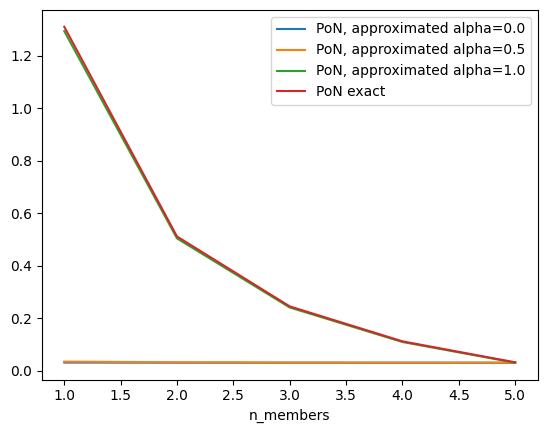

In [34]:
METRIC = "mse"
for alpha in [0., 0.5, 1.0]:
    model_name = f'pon_model_0_approximated_{alpha}'
    metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                       label=f"PoN, approximated alpha={alpha}", 
                                                       # color="red", 
                                                       # alpha=alpha_plot[i]
                                                        )

metrics_df[METRIC]["mean"].loc['pon_model_0', :].plot(label="PoN exact"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

#### plot 6.2 homo noise per ensemble member

In [49]:
models = ["pon_model_0_approximated_0.0_per-ens-homo_500_epochs", 
          "pon_model_0_approximated_0.5_per-ens-homo_500_epochs", 
          "pon_model_0_approximated_1.0_per-ens-homo_500_epochs", 
          "pon_model_0_per-ens-homo"]

In [50]:
metrics_df = get_metrics(models)

pon_model_0_approximated_0.0_per-ens-homo_500_epochs
[[-0.44911543]
 [-0.44040057]
 [-0.3988323 ]
 [-0.44180915]
 [-0.45403928]]
(5, 138, 1)
(5, 138, 1)
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
droppi

In [51]:
metrics_df

H  \
                                                                  mean   
model_name                                         n_members             
pon_model_0_approximated_0.0_per-ens-homo_500_e... 1          0.982099   
                                                   2          0.981858   
                                                   3          0.981781   
                                                   4          0.981743   
                                                   5          0.981720   
pon_model_0_approximated_0.5_per-ens-homo_500_e... 1          1.243508   
                                                   2          1.243232   
                                                   3          1.243144   
                                                   4          1.243101   
                                                   5          1.243075   
pon_model_0_approximated_1.0_per-ens-homo_500_e... 1          1.381744   
                                                   2          1.381651   
                                                   3          1.381620   
                                                   4          1.381604   
                                                   5          1.381594   
pon_model_0_per-ens-homo                           1          1.385466   
                                                   2          1.385418   
                                                   3          1.385401   
                                                   4          1.385393   
                                                   5          1.385388   

                                                                              \
                                                                   std count   
model_name                                         n_members                   
pon_model_0_approximated_0.0_per-ens-homo_500_e... 1          0.021957     5   
                                                   2          0.012416    10   
                                                   3          0.008222    10   
                                                   4          0.005322     5   
                                                   5               NaN     1   
pon_model_0_approximated_0.5_per-ens-homo_500_e... 1          0.023466     5   
                                                   2          0.013255    10   
                                                   3          0.008774    10   
                                                   4          0.005679     5   
                                                   5               NaN     1   
pon_model_0_approximated_1.0_per-ens-homo_500_e... 1          0.013681     5   
                                                   2          0.007905    10   
                                                   3          0.005271    10   
                                                   4          0.003424     5   
                                                   5               NaN     1   
pon_model_0_per-ens-homo                           1          0.009854     5   
                                                   2          0.005684    10   
                                                   3          0.003788    10   
                                                   4          0.002460     5   
                                                   5               NaN     1   

                                                              mse_diff  \
                                                                  mean   
model_name                                         n_members             
pon_model_0_approximated_0.0_per-ens-homo_500_e... 1          0.000404   
                                                   2          0.000152   
                                                   3          0.000067   
                                                   4          0.000025   
       

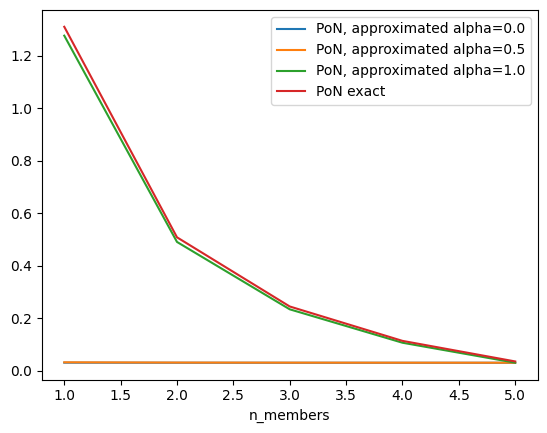

In [26]:
METRIC = "mse"
for alpha in [0., 0.5, 1.0]:
    model_name = f'pon_model_0_approximated_{alpha}_per-ens-homo_500_epochs'
    metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                       label=f"PoN, approximated alpha={alpha}", 
                                                       # color="red", 
                                                       # alpha=alpha_plot[i]
                                                        )

metrics_df[METRIC]["mean"].loc['pon_model_0_per-ens-homo', :].plot(label="PoN exact"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

### plot 7: stochastic sampling during training

see runs 264-266 on wandb for training curves when stochastic sampling is used

In [35]:
models = [f"pog_model_0_GND_{alpha}_2{stoch_sampl}" for alpha in [0.0, 0.5, 1.0] for stoch_sampl in ["", "_stochastic_sampling"]]
models = models + [x + "_300_epochs" for x in models]

In [36]:
models

['pog_model_0_GND_0.0_2',
 'pog_model_0_GND_0.0_2_stochastic_sampling',
 'pog_model_0_GND_0.5_2',
 'pog_model_0_GND_0.5_2_stochastic_sampling',
 'pog_model_0_GND_1.0_2',
 'pog_model_0_GND_1.0_2_stochastic_sampling',
 'pog_model_0_GND_0.0_2_300_epochs',
 'pog_model_0_GND_0.0_2_stochastic_sampling_300_epochs',
 'pog_model_0_GND_0.5_2_300_epochs',
 'pog_model_0_GND_0.5_2_stochastic_sampling_300_epochs',
 'pog_model_0_GND_1.0_2_300_epochs',
 'pog_model_0_GND_1.0_2_stochastic_sampling_300_epochs']

In [37]:
metrics_df = get_metrics(models)

pog_model_0_GND_0.0_2
[0.11960569]
dropping 4 infs for prod of 1
dropping 4 infs for prod of 1
dropping 1 infs for prod of 1
dropping 2 infs for prod of 1
dropping 2 infs for prod of 1
dropping 8 infs for prod of 2
dropping 5 infs for prod of 2
dropping 6 infs for prod of 2
dropping 4 infs for prod of 2
dropping 5 infs for prod of 2
dropping 6 infs for prod of 2
dropping 6 infs for prod of 2
dropping 2 infs for prod of 2
dropping 3 infs for prod of 2
dropping 4 infs for prod of 2
dropping 9 infs for prod of 3
dropping 10 infs for prod of 3
dropping 8 infs for prod of 3
dropping 6 infs for prod of 3
dropping 5 infs for prod of 3
dropping 6 infs for prod of 3
dropping 6 infs for prod of 3
dropping 7 infs for prod of 3
dropping 8 infs for prod of 3
dropping 4 infs for prod of 3
dropping 10 infs for prod of 4
dropping 9 infs for prod of 4
dropping 10 infs for prod of 4
dropping 6 infs for prod of 4
dropping 8 infs for prod of 4
dropping 10 infs for prod of 5
pog_model_0_GND_0.0_2_stochasti

dropping 5 infs for prod of 3
dropping 4 infs for prod of 3
dropping 1 infs for prod of 3
dropping 3 infs for prod of 3
dropping 2 infs for prod of 3
dropping 3 infs for prod of 3
dropping 5 infs for prod of 4
dropping 5 infs for prod of 4
dropping 4 infs for prod of 4
dropping 5 infs for prod of 4
dropping 3 infs for prod of 4
dropping 5 infs for prod of 5
pog_model_0_GND_0.5_2_stochastic_sampling_300_epochs
[-0.10144322]
dropping 2 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 1 infs for prod of 1
dropping 2 infs for prod of 1
dropping 2 infs for prod of 2
dropping 3 infs for prod of 2
dropping 3 infs for prod of 2
dropping 4 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 2 infs for prod of 2
dropping 1 infs for prod of 2
dropping 3 infs for prod of 2
dropping 3 infs for prod of 2
dropping 3 infs for prod of 3
dropping 3 infs for prod of 3
dropping 4 infs for prod of 3
dropping 3 infs for prod of 3
dro

In [38]:
metrics_df

H  \
                                                                  mean   
model_name                                         n_members             
pog_model_0_GND_0.0_2                              1          0.812753   
                                                   2          0.269550   
                                                   3         -0.069124   
                                                   4         -0.283846   
                                                   5         -0.426960   
pog_model_0_GND_0.0_2_300_epochs                   1          0.818447   
                                                   2          0.287287   
                                                   3         -0.043642   
                                                   4         -0.254222   
                                                   5         -0.395318   
pog_model_0_GND_0.0_2_stochastic_sampling          1          0.708769   
                                                   2          0.182551   
                                                   3         -0.125538   
                                                   4         -0.270367   
                                                   5         -0.318619   
pog_model_0_GND_0.0_2_stochastic_sampling_300_e... 1          0.702768   
                                                   2          0.150880   
                                                   3         -0.173429   
                                                   4         -0.324191   
                                                   5         -0.370796   
pog_model_0_GND_0.5_2                              1          0.462554   
                                                   2          0.140133   
                                                   3         -0.045721   
                                                   4         -0.160948   
                                                   5         -0.236941   
pog_model_0_GND_0.5_2_300_epochs                   1          0.462554   
                                                   2          0.140133   
                                                   3         -0.045721   
                                                   4         -0.160948   
                                                   5         -0.236941   
pog_model_0_GND_0.5_2_stochastic_sampling          1          0.591704   
                                                   2          0.190337   
                                                   3         -0.041912   
                                                   4         -0.162259   
                                                   5         -0.217532   
pog_model_0_GND_0.5_2_stochastic_sampling_300_e... 1          0.591704   
                                                   2          0.190337   
                                                   3         -0.041912   
                                                   4         -0.162259   
                                                   5         -0.217532   
pog_model_0_GND_1.0_2                              1          0.198243   
                                                   2          0.117380   
                                                   3          0.075209   
                                                   4          0.048580   
                                                   5          0.029879   
pog_model_0_GND_1.0_2_300_epochs                   1          0.047994   
                                                   2         -0.054343   
                                                   3         -0.108818   
                                                   4         -0.145012   
                                                   5         -0.171617   
pog_model_0_GND_1.0_2_stochastic_sampling          1          0.486491   
                                                   2          0.325532   

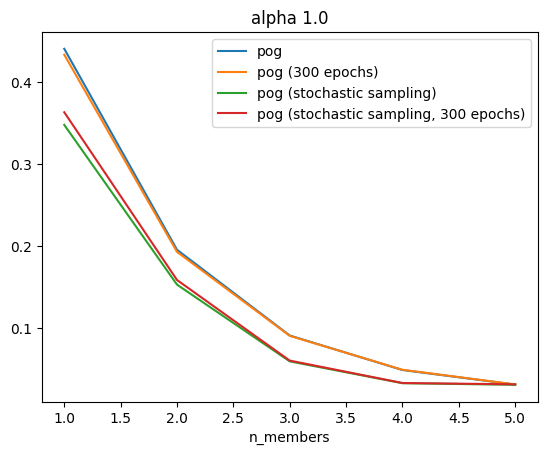

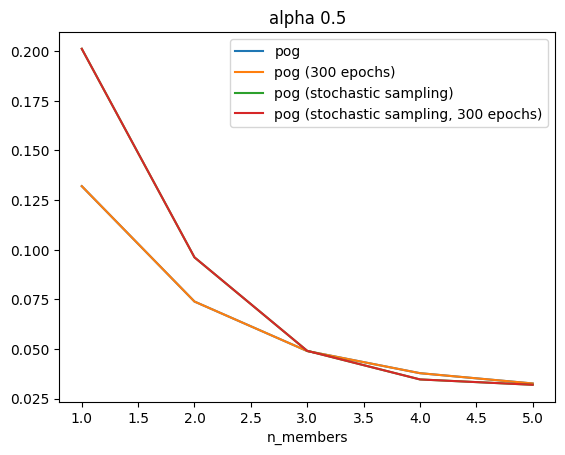

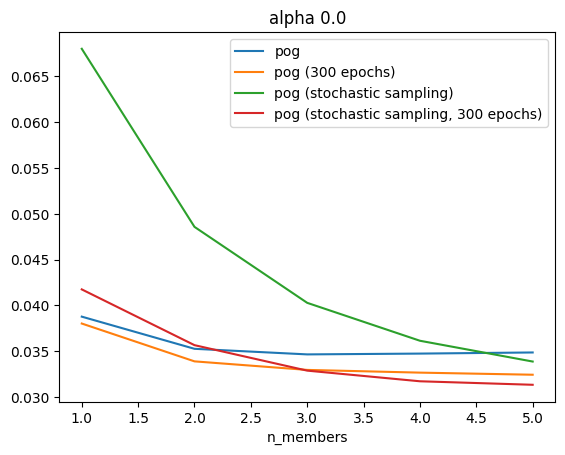

In [40]:
METRIC = "mse"
for alpha in [0.0, 0.5, 1.0]:
    model_name = f'pog_model_0_GND_{alpha}_2'
    
    metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                       label=f"pog", 
                                                       # color="red", 
                                                       # alpha=alpha_plot[i]
                                                        )
    metrics_df[METRIC]["mean"].loc[model_name + "_300_epochs", :].plot( 
                                                       label=f"pog (300 epochs)", 
                                                       # color="red", 
                                                       # alpha=alpha_plot[i]
                                                        )
    metrics_df[METRIC]["mean"].loc[model_name + "_stochastic_sampling", :].plot( 
                                                       label=f"pog (stochastic sampling)", 
                                                       # color="red", 
                                                       # alpha=alpha_plot[i]
                                                        )
    metrics_df[METRIC]["mean"].loc[model_name + "_stochastic_sampling_300_epochs", :].plot( 
                                                       label=f"pog (stochastic sampling, 300 epochs)", 
                                                       # color="red", 
                                                       # alpha=alpha_plot[i]
                                                        )
    plt.title(f"alpha {1 - alpha}")
    plt.legend()
    plt.show()

### plot 8: pogmm

In [56]:
models = ["ens_model_0",
          "pogmm_model_0_0.0",
          "pogmm_model_0_0.5",
          "pogmm_model_0_1.0"]

In [57]:
metrics_df = get_metrics(models)

ens_model_0
[-1.372305]
pogmm_model_0_0.0
[-0.7316258]
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 1
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 2
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 3
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 4
dropping 0 infs for pon of 5
pogmm_model_0_0.5
[-0.40019572]
dropping 0 inf

In [54]:
metrics_df

H                      mse_diff            \
                                 mean           std count      mean       std   
model_name        n_members                                                     
ens_model_0       1          0.046633  1.408731e-08     5  0.000790  0.000909   
                  2          0.050384  3.120421e-03    10  0.000296  0.000146   
                  3          0.051646  2.758883e-03    10  0.000132  0.000058   
                  4          0.052287  2.017222e-03     5  0.000049  0.000051   
                  5          0.052676           NaN     1  0.000000       NaN   
pogmm_model_0_0.0 1          0.421816  6.261549e-01     5  0.465423  0.631713   
                  2         -0.593258  3.419793e-01    10  0.065195  0.201492   
                  3         -1.110191  1.251635e-02    10  0.000493  0.001250   
                  4         -1.399808  7.119782e-03     5  0.000172  0.000828   
                  5         -1.623935           NaN     1  0.000000       NaN   
pogmm_model_0_0.5 1          1.093154  6.243225e-01     5  0.695363  1.004368   
                  2          0.087155  3.091283e-01    10  0.121640  0.363003   
                  3         -0.423821  6.519256e-03    10  0.002702  0.005147   
                  4         -0.714585  4.442343e-03     5  0.000997  0.002998   
                  5         -0.938874           NaN     1  0.000000       NaN   
pogmm_model_0_1.0 1          1.710841  5.505904e-01     5  0.953144  1.010946   
                  2          0.817924  2.721902e-01    10  0.234751  0.426421   
                  3          0.297201  8.576080e-02    10  0.036359  0.025178   
                  4         -0.039239  2.631259e-02     5  0.012051  0.010413   
                  5         -0.277517           NaN     1  0.000000       NaN   

                                        mse                  nll_diff  \
                            count      mean       std count      mean   
model_name        n_members                                             
ens_model_0       1             5  0.030585  0.000909     5  0.002403   
                  2            10  0.030091  0.000146    10  0.000835   
                  3            10  0.029927  0.000058    10  0.000373   
                  4             5  0.029845  0.000051     5  0.000141   
                  5             1  0.029795       NaN     1  0.000000   
pogmm_model_0_0.0 1             5  0.496587  0.631713     5 -4.542649   
                  2            10  0.096359  0.201492    10 -4.746452   
                  3            10  0.031658  0.001250    10 -3.846631   
                  4             5  0.031336  0.000828     5 -2.225656   
                  5             1  0.031164       NaN     1  0.000000   
pogmm_model_0_0.5 1             5  0.729262  1.004368     5  0.259480   
                  2            10  0.155539  0.363003    10 -0.526185   
                  3            10  0.036601  0.005147    10 -0.648494   
                  4             5  0.034896  0.002998     5 -0.425010   
                  5             1  0.033899       NaN     1  0.000000   
pogmm_model_0_1.0 1             5  0.986328  1.010946     5  1.607348   
                  2            10  0.267935  0.426421    10  0.813304   
                  3            10  0.069543  0.025178    10  0.390834   
                  4             5  0.045235  0.010413     5  0.153888   
                  5             1  0.033184       NaN     1  0.000000   

                                                  nll                  \
                                  std count      mean       std count   
model_name        n_members                                             
ens_model_0       1          0.007068     5 -0.215439  0.007068     5   
                  2          0.002860    10 -0.217007  0.002860    10   
                  3          0.001680    10 -0.217469  0.001680    10   
                  4          0.001017     5 -0.217700 

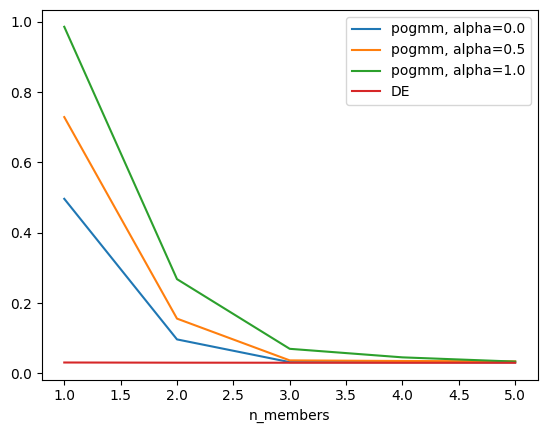

In [58]:
METRIC = "mse"
model_name = "pogmm_model_0_"
for alpha in [0.0, 0.5, 1.0]:
    
    metrics_df[METRIC]["mean"].loc[model_name + str(alpha), :].plot( 
                                                       label=f"pogmm, alpha={alpha}", 
                                                       # color="red", 
                                                       # alpha=alpha_plot[i]
                                                        )
metrics_df[METRIC]["mean"].loc["ens_model_0", :].plot( 
                                                       label=f"DE", 
                                                       # color="red", 
                                                       # alpha=alpha_plot[i]
                                                        )
plt.legend()
plt.show()

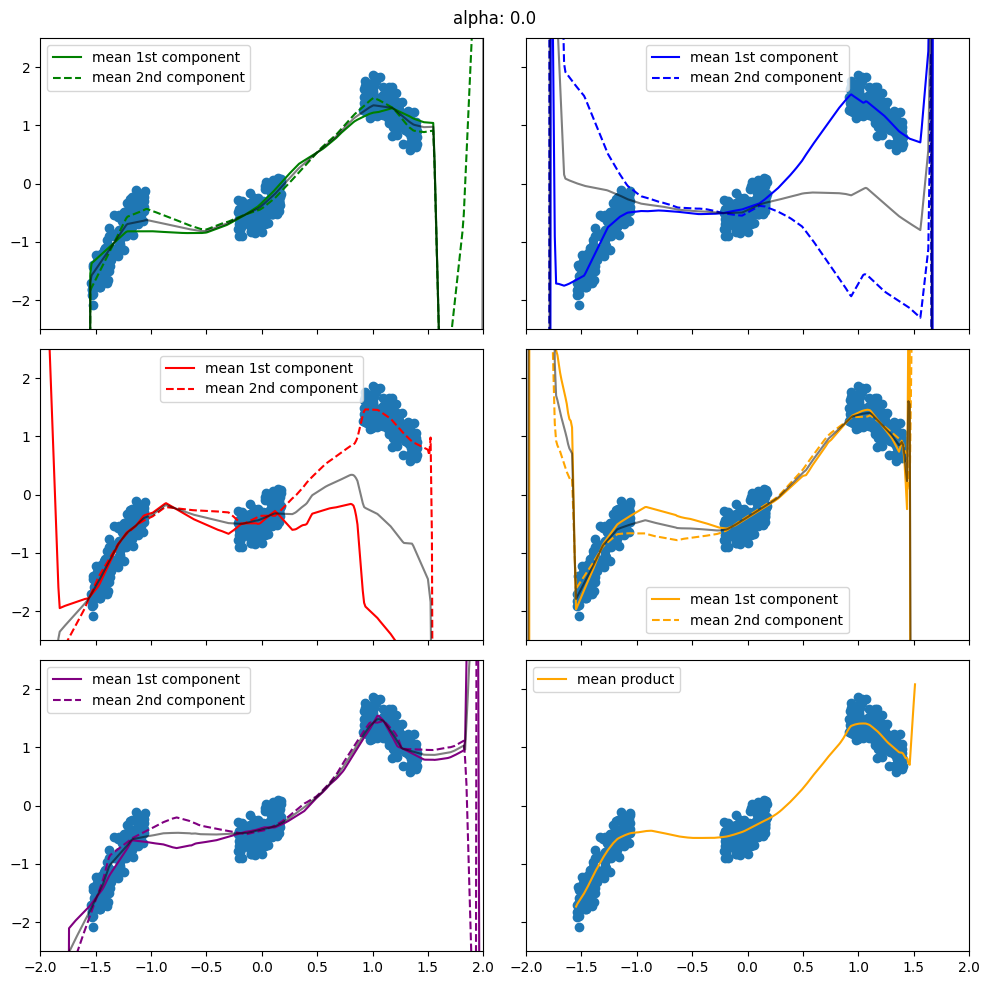

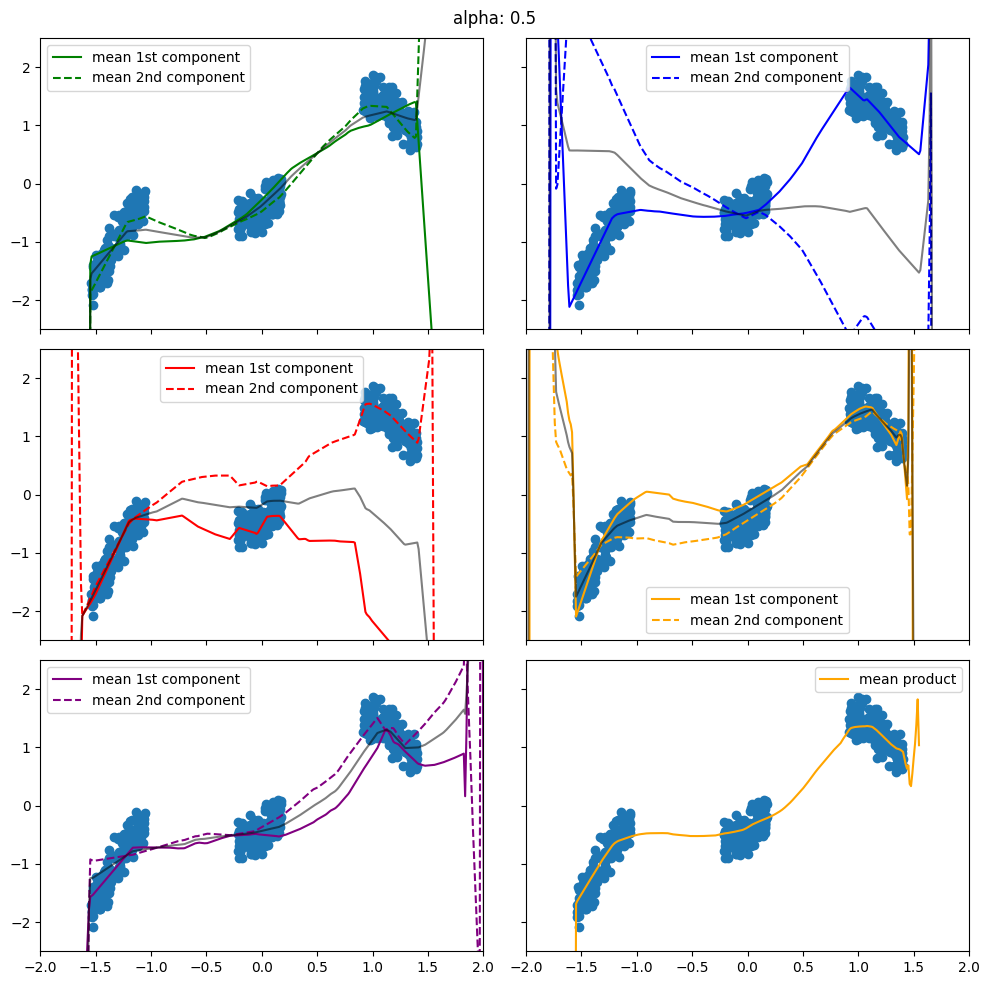

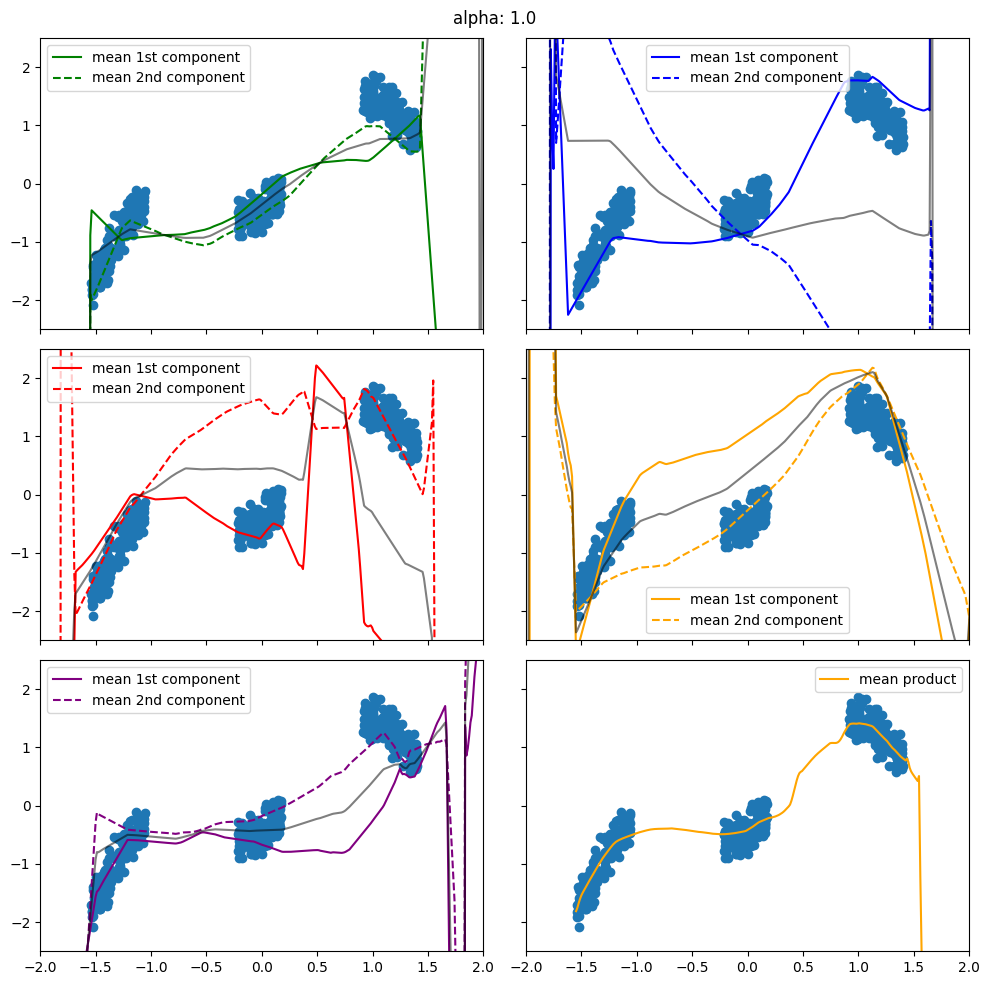

In [89]:
for alpha in [0.0, 0.5, 1.0]:
    model_type = pogmm_model
    model_name = "pogmm_model_0_" + str(alpha)
    state = restore_checkpoint(f'dynNN_results/{model_name}', 1)

    xs = jnp.linspace(-3, 3, num=501)

    pred_fun = partial(
                    model_type.apply,
                    {"params": state['params'], **state['model_state']},
                    train=False, return_ens_preds=True,
                    method=model_type.pred
                )
    (loc, scale), (locs, scales) = jax.vmap(
        pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
    )(xs.reshape(-1, 1))

    locs_0 = locs[:, :, 0]
    locs_1 = locs[:, :, 1]

    color_dict = {0: "green", 1: "blue", 2: "red", 3: "orange", 4: "purple"}

    fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10, 10))


    for i in range(locs_0.shape[0]):

        ax[i // 2, i % 2].scatter(X_train, y_train, c='C0')
        ax[i // 2, i % 2].plot(xs, locs_0[i], color=color_dict[i], label="mean 1st component")
        ax[i // 2, i % 2].plot(xs, locs_1[i], linestyle="--", color=color_dict[i], label="mean 2nd component")
        ax[i // 2, i % 2].plot(xs, 0.5 * locs_0[i] + 0.5 * locs_1[i], alpha=0.5, color="black")
        # ax.plot(xs, locs_1[i], alpha=0.5, linestyle="--", color=color_dict[i])
        # axs[1].fill_between(xs, locs_0[i] - scales[i], locs_0[i] + scales[i], alpha=0.1, color=color_dict[i])
        # axs[1].fill_between(xs, locs_1[i] - scales[i], locs_1[i] + scales[i], alpha=0.1, color=color_dict[i])
        ax[i // 2, i % 2].set_ylim(-2.5, 2.5)
        ax[i // 2, i % 2].set_xlim(-2, 2)
        ax[i // 2, i % 2].legend()


    ax[2, 1].scatter(X_train, y_train, c='C0')
    ax[2, 1].plot(xs, loc, color="orange", label="mean product")
    ax[2, 1].legend()
    plt.suptitle(f"alpha: {alpha}")
    plt.tight_layout()
    plt.show()

### why is there a difference for alpha=1.0 (so we ignore product term completely) and beta=2? isn't for beta=2 GND supposed to be equal to gaussian?

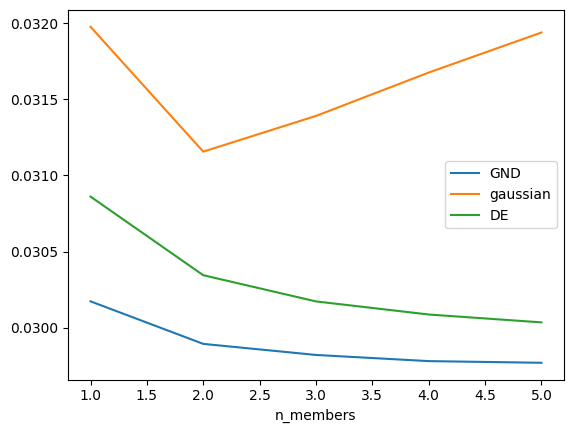

In [82]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{1.0}_{2}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{1.0}_{2}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

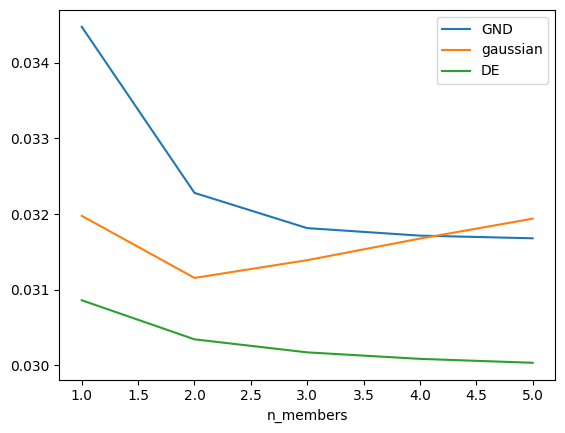

In [20]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{1.0}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{1.0}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

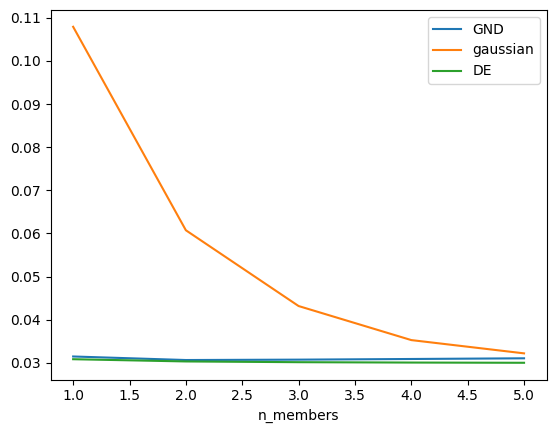

In [34]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.5}_{2}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{0.5}_{2}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

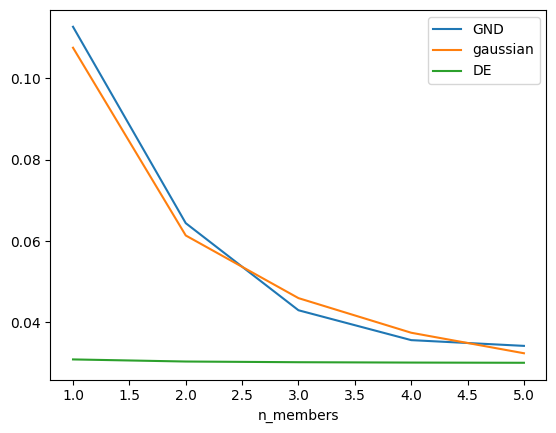

In [22]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.5}_{8}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{0.5}_{8}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

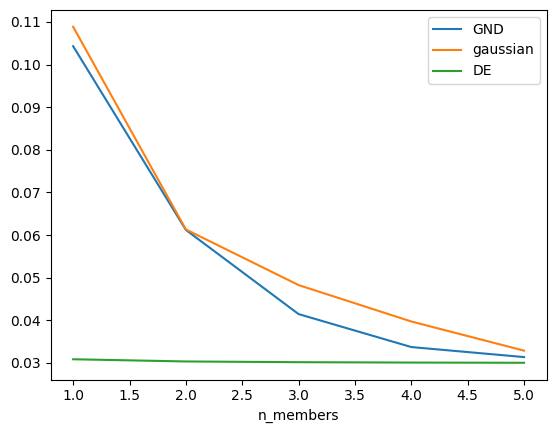

In [23]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.5}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{0.5}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

#### compare predictive distributions

In [24]:
models = ["pog_model_0_gaussian_1.0_2", "pog_model_0_GND_1.0_2"]

In [25]:
for model_name in models:
    print(model_name)
    if "pog" in model_name:
        model_type = pog_model
        state = restore_checkpoint(f'dynNN_results/{model_name}', 1)
    elif "ens" in model_name:
        model_type = ens_model
        state = restore_checkpoint(f'dynNN_results/{model_name}', 1)["0"]

    pred_fun = partial(
        model_type.apply,
        {"params": state['params'], **state['model_state']},
        train=False, return_ens_preds=True,
        method=model_type.pred
    )
    _, (locs, scales) = jax.vmap(
        pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
    )(jnp.array(X_test))
    
    for i in range(5):
        print(i)
        loc, scale = calculate_pog_loc_scale(locs[(i,), :, 0], scales[(i,), :, 0])
        errors = jax.vmap(mse)(loc, jnp.array(y_test))
        loc_de, scale_de = calculate_ens_loc_scale(locs[(i,), :, 0], scales[(i,), :, 0], 1)
        errors_de = jax.vmap(mse)(loc_de, jnp.array(y_test))
        print(errors.mean())
        print(errors_de.mean())

pog_model_0_gaussian_1.0_2
0
0.030165693
0.030165693
1
0.032101937
0.032101937
2
0.035763014
0.035763014
3
0.031322356
0.031322356
4
0.030530985
0.030530985
pog_model_0_GND_1.0_2
0
0.029811466
0.029811462
1
0.030464621
0.03046462
2
0.029827299
0.029827295
3
0.030753948
0.030753948
4
0.030005338
0.030005338


In [26]:
model_type = ens_model
state = restore_checkpoint(f'dynNN_results/ens_model_0', 1)["0"]

pred_fun = partial(
    model_type.apply,
    {"params": state['params'], **state['model_state']},
    train=False, return_ens_preds=True,
    method=model_type.pred
)
_, (locs, scales) = jax.vmap(
    pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
)(jnp.array(X_test))

In [66]:
model_type = pog_model
state = restore_checkpoint(f'dynNN_results/pog_model_0_GND_0.0_16', 1)

pred_fun = partial(
    model_type.apply,
    {"params": state['params'], **state['model_state']},
    train=False, return_ens_preds=True,
    method=model_type.pred
)
_, (locs_gnd, scales_gnd) = jax.vmap(
    pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
)(jnp.array(X_test))

In [67]:
def mean_confidence_interval(data, confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

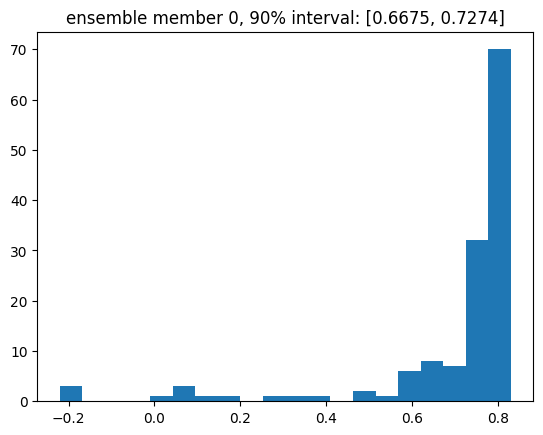

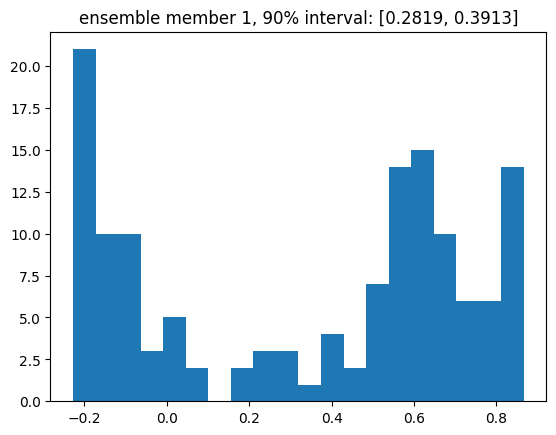

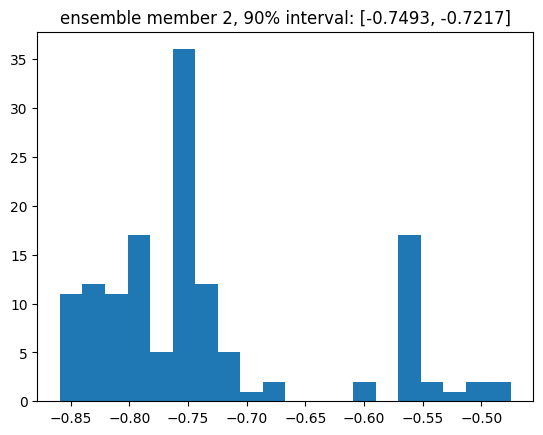

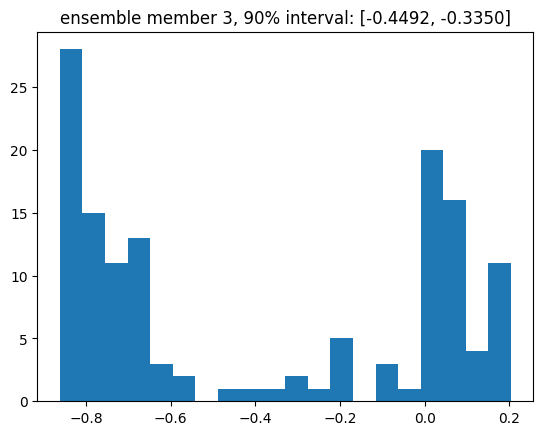

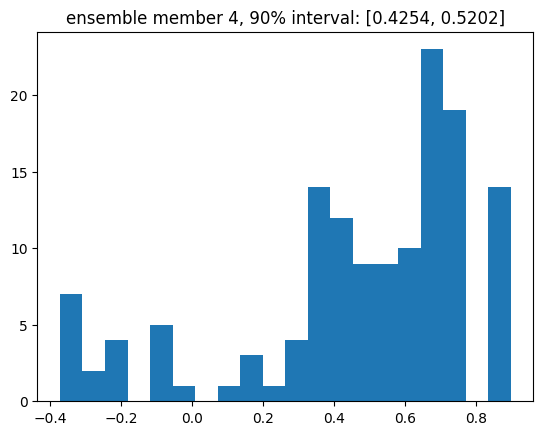

In [68]:
for i in range(5):
    pred_diffs = np.array(locs[i, :, :] - locs_gnd[i, :, :])
    plt.hist(pred_diffs, bins=20)
    _, l, r = mean_confidence_interval(pred_diffs)
    plt.title(f"ensemble member {i}, 90% interval: [{l[0]:.4f}, {r[0]:.4f}]")
    plt.show()

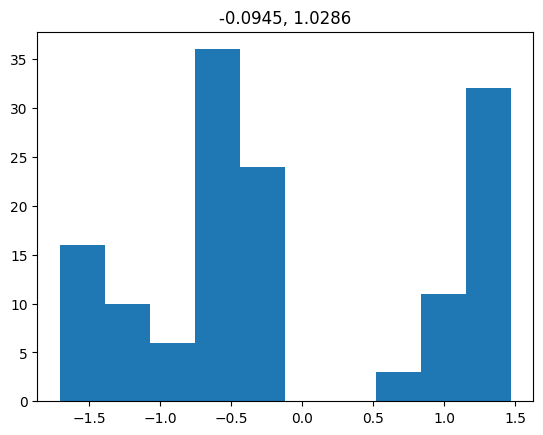

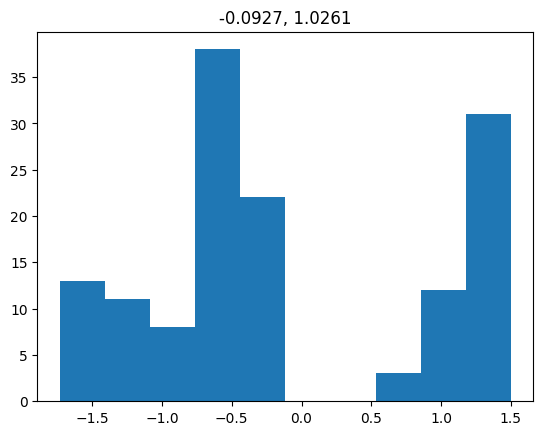

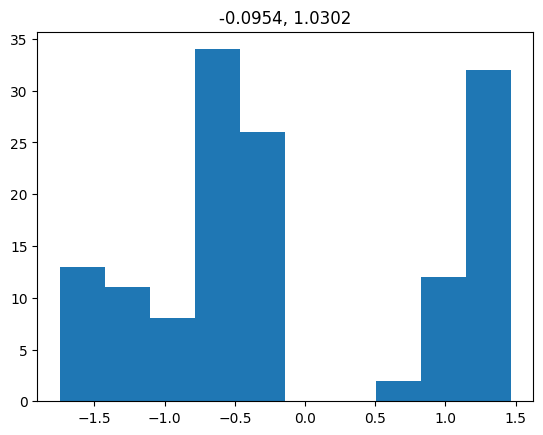

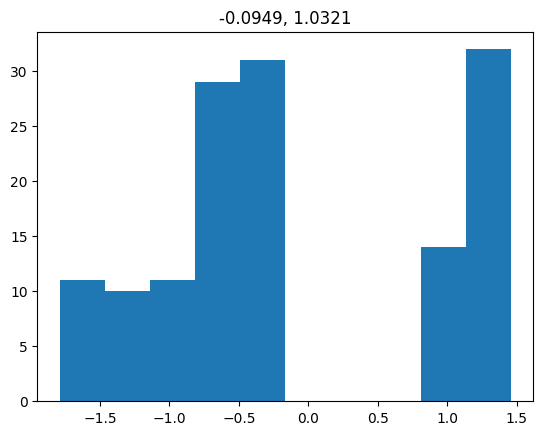

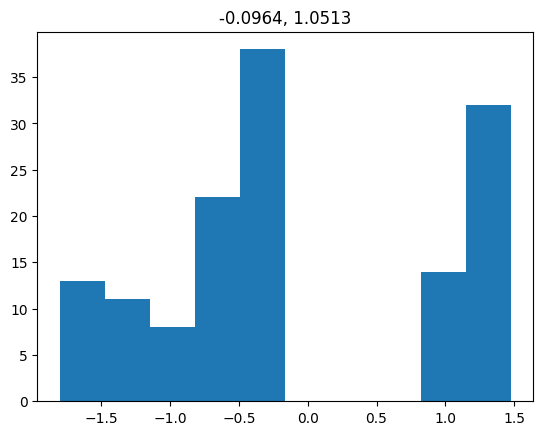

In [60]:
for i in range(5):
    preds = np.array(locs[i, :, :])
    plt.hist(preds, bins=10)
    plt.title(f"{preds.mean():.4f}, {preds.std():.4f}")
    plt.show()

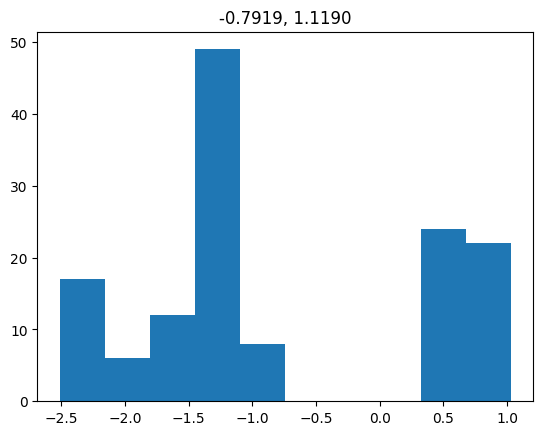

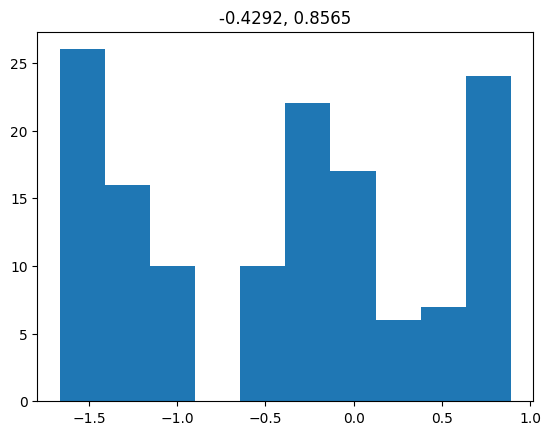

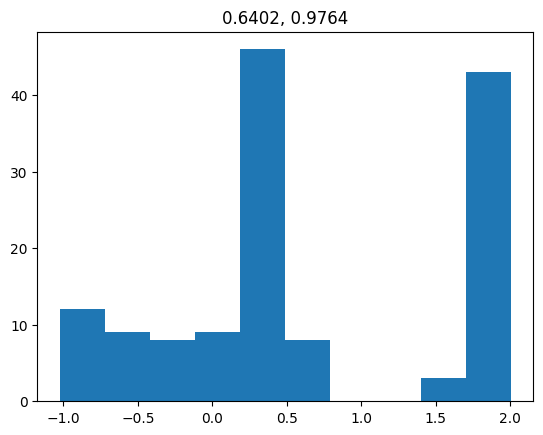

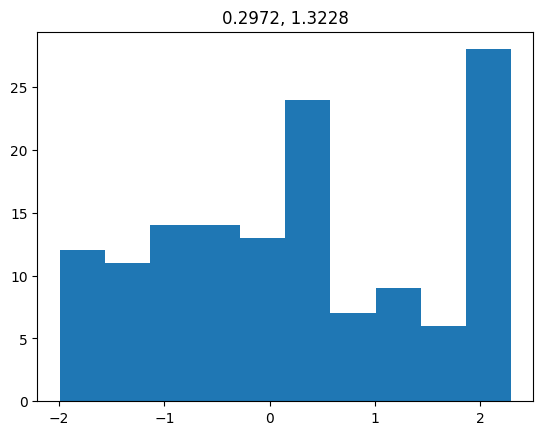

In [69]:
for i in range(5):
    preds = np.array(locs_gnd[i, :, :])
    plt.hist(preds, bins=10)
    plt.title(f"{preds.mean():.4f}, {preds.std():.4f}")
    plt.show()

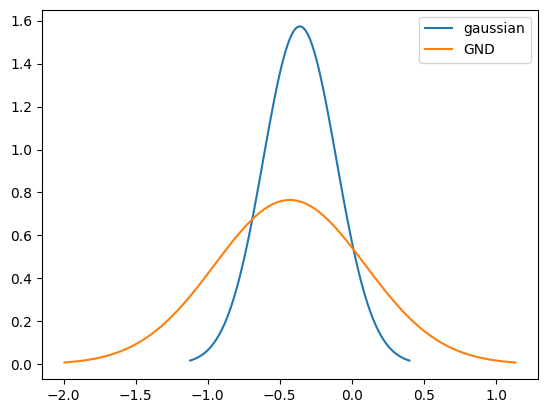

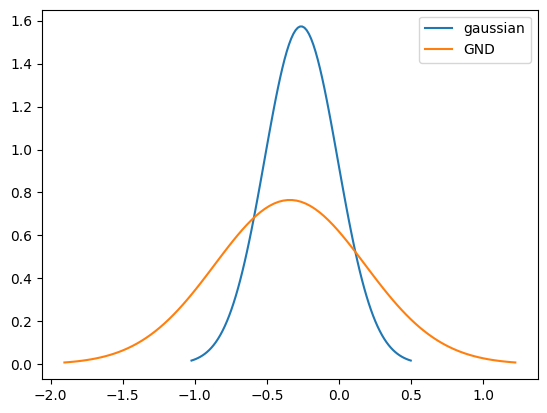

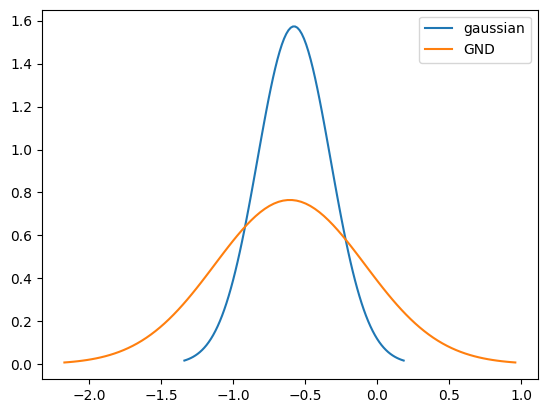

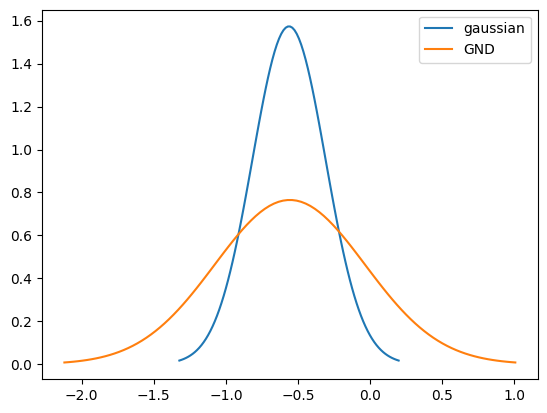

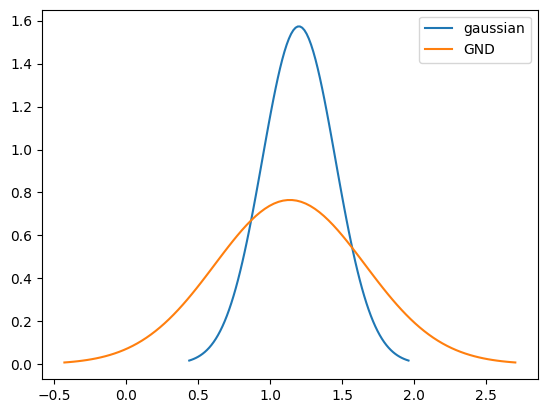

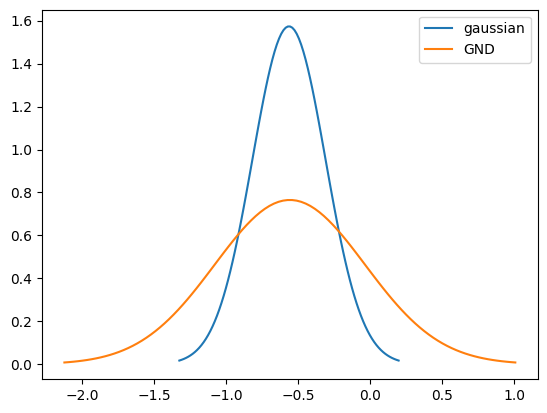

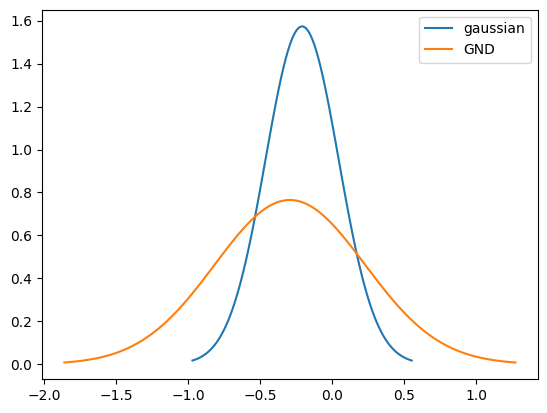

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

m = 0
for i in range(10):
    mu = locs[m, i, :]
    sigma = scales[m, i, :]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label="gaussian")
    
    mu = locs_gnd[m, i, :]
    sigma = scales_gnd[m, i, :]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label="GND")
    
    plt.legend()
    plt.show()

## batch norm

In [10]:
model_name = "pog_model_0_GND_0.5_2"
model_type = pog_model
state = restore_checkpoint(f'dynNN_results/{model_name}', 1)

In [11]:
state.keys()

dict_keys(['step', 'params', 'opt_state', 'model_state', 'β'])

In [15]:
state["params"].keys()

dict_keys(['logscale', 'nets_0', 'nets_1', 'nets_2', 'nets_3', 'nets_4', 'weights'])

In [14]:
state["model_state"].keys()

dict_keys(['batch_stats'])

In [20]:
locs

DeviceArray([[[-0.8714445 ],
              [ 1.0409899 ],
              [-0.79339504],
              [-0.6956121 ],
              [-0.9761603 ],
              [-0.8193034 ],
              [ 0.7844572 ],
              [-0.81970537],
              [ 0.62067986],
              [-0.64567864],
              [ 0.800452  ],
              [-0.731838  ],
              [ 1.1705513 ],
              [-1.4380423 ],
              [ 1.0955942 ],
              [ 1.0691693 ],
              [ 1.1669095 ],
              [-0.9861102 ],
              [ 0.43591252],
              [-0.69378495],
              [-0.8115541 ],
              [-1.0112923 ],
              [-0.8290261 ],
              [ 1.0688562 ],
              [-0.9146649 ],
              [-0.82195175],
              [-0.9294143 ],
              [-0.8573438 ],
              [ 0.82471704],
              [-1.0123385 ],
              [-1.4944323 ],
              [ 0.6820487 ],
              [-0.96385586],
              [-2.05395   ],
              